In [19]:
%matplotlib inline

# importing system packages
import os
import sys
import glob
import h5py
import time
import itertools
from tqdm import tqdm, trange

# importing the workhorse
import numpy as np
import pandas as pd
from scipy import io, signal, interpolate, ndimage,stats

# tiff packages
import tifffile

# import all plotting packages
import matplotlib.pyplot as plt
from matplotlib import colors, cm, gridspec,pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

# Style sheet
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['pcolor.shading'] = 'auto'

# import bokeh
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.palettes import Inferno256, Cividis256, inferno, cividis, viridis
from bokeh.models import LinearColorMapper, LogColorMapper, Div
from bokeh.layouts import gridplot, column, row

# import all fitting packages
from lmfit import Minimizer, Parameters, report_fit

from visReduce import *
from XPCSana import *
from Hao_XPCS_utils import *
import shot_object_v2 as ss
from single_shot_helper_functions import *
from Hao_speckle_utils_v2_2 import *
from fit1D import *

import pickle
import copy

# smdDir = '/cds/data/drpsrcf/xcs/xcsly3520/scratch/hdf5/smalldata'

In [20]:
def plottable_lists_from_meanstd_dict(data_dict):
    items=sorted(data_dict.items())
#     if not 'mean' in items[0][1].keys() or not 'std' in items[0][1].keys():
#         print('Dict is not in the right format!')
#         return
    
    keys=[items[k][0] for k in range(len(items))]
    means=[items[k][1]['mean'] for k in range(len(items))]
    stds=[items[k][1]['std err'] for k in range(len(items))]
    return keys,means,stds

In [21]:
# runIDs=list(range(19,33))
# runIDs=list(range(34,47))
# runIDs=[256]
# runIDs=[259]
# runIDs=[260]
# runIDs=[232,234]
runIDs=[232,234,256]
# runIDs=list(range(228,235))
# runIDs=[216,217]

print(runIDs)
epix=3
before_num=3
after_num=17
total_rows=29

final_check_num=10

# figsaveloc='runs19-32'
# figsaveloc='runs34-46'
# figsaveloc='runs228-234_figs'
# figsaveloc='runs216-217_figs'
# figsaveloc='run256_figs_biggerRaw'
# figsaveloc='run256_figs_q-sweep'
# figsaveloc='runs232-234 256_figs'
# figsaveloc='runs232-234 256_figs/3-transient-pulses'
# figsaveloc='runs232-234 256_figs2'
figsaveloc='runs232-234 256_figs_q-sweep'
# figsaveloc='runs232-234 256_figs_smoothed-q-sweep'
# figsaveloc='runs232-234 256_figs_normed-q-sweep_ROI{}'.format(ROI_size)

if not os.path.isdir(figsaveloc):
    os.makedirs(figsaveloc)

[232, 234, 256]


In [25]:
i0_thres=100
pix_thres=44
ROI_size=100
detector=3
qxoffs=[]
qyoffs=[]
delta_ROI=[(qx,qy) for qx in qxoffs for qy in qyoffs]
delta_ROI.append((0,0))
# delta_ROI.remove((0,0))
print(delta_ROI)

[(0, 0)]


In [27]:
combined_data_TT=dict.fromkeys(delta_ROI)
combined_data_is={}
for key in delta_ROI:
    combined_data_TT[key]={}
delta_ROI.remove((0,0))
qxoff=0
qyoff=0
additional_rows=total_rows-before_num-after_num-1
for runID in runIDs:
    source_folder='original_SSTTs/run{}/TT/Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
    .format(runID,detector,i0_thres,pix_thres,ROI_size,0,0)
    # source_folder='original_SSTTs/run{}/TT/Normed-SuttonStd-Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
    # .format(runID,detector,i0_thres,pix_thres,ROI_size,0,0)
    # source_folder='SS_data/run{}/TT/Normed-Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
    # .format(runID,detector,i0_thres,pix_thres,ROI_size,0,0)
    # source_folder='SS_data/run{}/TT/Subt-Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
    # .format(runID,detector,i0_thres,pix_thres,ROI_size,0,0)
    # source_folder='original_SSTTs/run{}/TT/Normed-Sutton-Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
    # .format(runID,detector,i0_thres,pix_thres,ROI_size,0,0)
#     source_folder='SS_data/run{}/TT/Normed-OnAfter-rectROI-2020-Sutton-Q-Sweep/epix3_i0-100_pix-44_ROI-2020_qxoff0_qyoff0_no-photonization'
    # source_folder='SS_data/run{}/TT/Gorfmann-Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
    # .format(runID,detector,i0_thres,pix_thres,ROI_size,0,0)
    # source_folder='SS_data/run{}/TT/CircleROI-Q-Sweep/FullCircleROI/Gorfmann/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
    # .format(runID,detector,i0_thres,pix_thres,ROI_size,0,0)
#     source_folder='SS_data/run{}/TT/i0-{}_pix-{}_ROI-{}_no-photonization'.format(runID,i0_thres,pix_thres,ROI_size)
    tifflist=glob.glob(source_folder+'/TT*.tiff')
    # print(tifflist)
    npzlist=glob.glob(source_folder+'/*.npz')
    # print(npzlist)
    if not len(npzlist)==len(tifflist):
        print('file mismatch')
        continue
    for tiff in tqdm(tifflist):
        split_list=tiff.split('_')
        delay=int(split_list[len(split_list)-1].split('.')[0])
        if not delay in combined_data_TT[(qxoff,qyoff)].keys():
            combined_data_TT[(qxoff,qyoff)][delay]=[]
        TT=tifffile.imread(tiff)
#         print(TT.shape)
        combined_data_TT[(qxoff,qyoff)][delay].extend([*TT])
    for npzfile in npzlist:
        split_list=npzfile.split('_')
        delay=int(split_list[len(split_list)-1].split('.')[0])
        if not delay in combined_data_is.keys():
            combined_data_is[delay]=[]
        f=np.load(npzfile)
        norm_is_on=f['norm_is_on']
        norm_is_after=f['norm_is_after']
        avg_i_ratio_transient=np.array([np.nanmean(norm_is_on[k,0]*(norm_is_after[k,2:]**-1)) for k in range(norm_is_on.shape[0])])
        combined_data_is[delay].extend([*avg_i_ratio_transient])
        avg_i_ratio_additional=[]
        additional_delays=[]
        for j in range(additional_rows):
            avg_i_ratio_additional.append(
                np.array(
                    [np.nanmean(norm_is_after[k,j]*(norm_is_after[k,additional_rows:]**-1)) for k in range(norm_is_on.shape[0])]
                )
            )
            additional_delays.append(3.33e7*(j+1))
            if not additional_delays[-1] in combined_data_is.keys():
                combined_data_is[additional_delays[-1]]=[]
            combined_data_is[additional_delays[-1]].extend([*avg_i_ratio_additional[-1]])
        if not 3.33e7*25 in combined_data_is.keys():
            combined_data_is[3.33e7*25]=[]
        final_i_ratio=np.array([np.nanmean(norm_is_after[k,-1]*(norm_is_after[k,additional_rows:]**-1)) for k in range(norm_is_on.shape[0])])
        combined_data_is[3.33e7*25].extend([*final_i_ratio])
        f.close()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.67it/s]
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\3512388711.py:49: RuntimeWarning: Mean of empty slice
  avg_i_ratio_transient=np.array([np.nanmean(norm_is_on[k,0]*(norm_is_after[k,2:]**-1)) for k in range(norm_is_on.shape[0])])
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\3512388711.py:56: RuntimeWarning: Mean of empty slice
  [np.nanmean(norm_is_after[k,j]*(norm_is_after[k,additional_rows:]**-1)) for k in range(norm_is_on.shape[0])]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\3512388711.py:65: RuntimeWarning: Mean of empty slice
  final_i_ratio=np.array([np.nanmean(norm_is_after[k,-1]*(norm_is_after[k,additional_rows:]**-1)) for k in range(norm_is_on.shape[0])])
100%|██████████████████████████████████████████████████████████████████████

In [29]:
for (qxoff,qyoff) in delta_ROI:
    for runID in runIDs:
#         source_folder='SS_data/run{}/TT/Normed-Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
#         .format(runID,detector,i0_thres,pix_thres,ROI_size,qxoff,qyoff)
#         source_folder='SS_data/run{}/TT/Smoothed-Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
#         .format(runID,detector,i0_thres,pix_thres,ROI_size,qxoff,qyoff)
        source_folder='original_SSTTs/run{}/TT/Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
        .format(runID,detector,i0_thres,pix_thres,ROI_size,qxoff,qyoff)
        # source_folder='SS_data/run{}/TT/Normed-OnAfter-rectROI-Sutton-Q-Sweep/epix{}_i0-{}_pix-{}_ROI-{}_qxoff{}_qyoff{}_no-photonization'\
        # .format(runID,detector,i0_thres,pix_thres,str(ROI_sizex)+str(ROI_sizey),qxoff,qyoff)
        tifflist=glob.glob(source_folder+'/*.tiff')
        for tiff in tqdm(tifflist):
            split_list=tiff.split('_')
            delay=int(split_list[len(split_list)-1].split('.')[0])
            if not delay in combined_data_TT[(qxoff,qyoff)].keys():
                combined_data_TT[(qxoff,qyoff)][delay]=[]
            TT=tifffile.imread(tiff)
#             print(TT.shape)
            combined_data_TT[(qxoff,qyoff)][delay].extend([*TT])

In [31]:
for (qxoff,qyoff) in combined_data_TT.keys():
    for delay in combined_data_TT[(qxoff,qyoff)]:
        combined_data_TT[(qxoff,qyoff)][delay]=np.array(combined_data_TT[(qxoff,qyoff)][delay])

In [33]:
combined_data_TT[(0,0)].keys()

dict_keys([3000000, 100, 1000, 10000, 100000, 300, 3000, 30000, 300000, 500, 800000])

In [35]:
on_after_corrs_shot_avg=dict.fromkeys(combined_data_TT.keys())
on_after_corrs_shot_var=dict.fromkeys(combined_data_TT.keys())
after_after_avg_corrs=dict.fromkeys(combined_data_TT.keys())
after_after_var_corrs=dict.fromkeys(combined_data_TT.keys())
additional_on_after_corrs_shot_avg=dict.fromkeys(combined_data_TT.keys())
additional_on_after_corrs_shot_var=dict.fromkeys(combined_data_TT.keys())
final_after_after_corrs_shot_avg=dict.fromkeys(combined_data_TT.keys())
final_after_after_corrs_shot_var=dict.fromkeys(combined_data_TT.keys())
for key in combined_data_TT.keys():
    on_after_corrs_shot_avg[key]=dict.fromkeys(combined_data_TT[key].keys())
    on_after_corrs_shot_var[key]=dict.fromkeys(combined_data_TT[key].keys())
    after_after_avg_corrs[key]=dict.fromkeys(combined_data_TT[key].keys())
    after_after_var_corrs[key]=dict.fromkeys(combined_data_TT[key].keys())
    additional_on_after_corrs_shot_avg[key]=dict.fromkeys(combined_data_TT[key].keys())
    additional_on_after_corrs_shot_var[key]=dict.fromkeys(combined_data_TT[key].keys())
    final_after_after_corrs_shot_avg[key]=dict.fromkeys(combined_data_TT[key].keys())
    final_after_after_corrs_shot_var[key]=dict.fromkeys(combined_data_TT[key].keys())
for (qxoff,qyoff) in combined_data_TT.keys():
    after_contrasts=[]
    print('(qx offset,qy offset)=',(qxoff,qyoff))
    for delay in sorted(combined_data_TT[(qxoff,qyoff)].keys()):
        contrasts=[]
        offsets=np.arange(1,after_num)
        on_after_corrs_shot_avg[(qxoff,qyoff)][delay]=[]
        after_after_avg_corrs[(qxoff,qyoff)][delay]=[]
        on_after_corrs_shot_var[(qxoff,qyoff)][delay]=[]
        after_after_var_corrs[(qxoff,qyoff)][delay]=[]
        additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay]=[]
        additional_on_after_corrs_shot_var[(qxoff,qyoff)][delay]=[]
        final_after_after_corrs_shot_avg[(qxoff,qyoff)][delay]=[]
        final_after_after_corrs_shot_var[(qxoff,qyoff)][delay]=[]
    #     plt.figure()
        for tt_ind in range(combined_data_TT[(qxoff,qyoff)][delay].shape[0]):
            local_contrasts=[]
            tt_after=combined_data_TT[(qxoff,qyoff)][delay][tt_ind,-after_num:,-after_num:]
    #         g2=gen_g2_from_g2mat(tt_after)
    #         plt.semilogx(g2[1])
            for offset in offsets:
                d=tt_after.diagonal(offset)
                #print(d[d>2])
                local_contrasts.extend(d)
            on_after_corrs_shot_avg[(qxoff,qyoff)][delay].append(
                np.nanmean(
                    combined_data_TT[(qxoff,qyoff)][delay][tt_ind,before_num,-after_num:]))
            on_after_corrs_shot_var[(qxoff,qyoff)][delay].append(
                np.nanvar(
                    combined_data_TT[(qxoff,qyoff)][delay][tt_ind,before_num,-after_num:]))
            local_after_corr=np.nanmean(local_contrasts)
            local_after_corr_var=np.nanvar(local_contrasts)
            after_after_avg_corrs[(qxoff,qyoff)][delay].append(local_after_corr)
            after_after_var_corrs[(qxoff,qyoff)][delay].append(local_after_corr_var)
            contrasts.append(local_after_corr)
            additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay].append(
                np.nanmean(
                    combined_data_TT[(qxoff,qyoff)][delay][tt_ind,before_num+1:-after_num,-after_num:],axis=1))
            additional_on_after_corrs_shot_var[(qxoff,qyoff)][delay].append(
                np.nanvar(
                    combined_data_TT[(qxoff,qyoff)][delay][tt_ind,before_num+1:-after_num,-after_num:],axis=1))
            final_after_after_corrs_shot_avg[(qxoff,qyoff)][delay].append(
                np.nanmean(
                    combined_data_TT[(qxoff,qyoff)][delay][tt_ind,-1,-final_check_num:-1]
                )
            )
            final_after_after_corrs_shot_var[(qxoff,qyoff)][delay].append(
                np.nanvar(
                    combined_data_TT[(qxoff,qyoff)][delay][tt_ind,-1,-final_check_num:-1]
                )
            )
    #     plt.ylim([0,1])
        contrasts=np.array(contrasts)
        contrast_aft_mean=np.nanmean(contrasts)
        after_contrasts.append(contrast_aft_mean)
        contrast_aft_std=np.sqrt(np.nansum(local_after_corr_var))
        additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay]=np.array(
            additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay])
        additional_on_after_corrs_shot_var[(qxoff,qyoff)][delay]=np.array(
            additional_on_after_corrs_shot_var[(qxoff,qyoff)][delay])
    #     after_after_avg_corrs[delay]['mean']=contrast_aft_mean
    #     after_after_avg_corrs[delay]['std']=contrast_aft_std
    #     diff_pix_baseline_betas[pix_thres]=beta_aft
        print('corr after',contrast_aft_mean, ', corr after std', contrast_aft_std,'N=',len(contrasts))
        avg_TT=np.nanmean(combined_data_TT[(qxoff,qyoff)][delay],axis=0)
        avg_TT[np.identity(avg_TT.shape[0],dtype=bool)]=np.nan
    #     plt.figure(figsize=(4,4))
#         displayImg(avg_TT,vmin=1,vmax=1.2,mode='pyplot',titleStr='$\overline{C}$'+'(t={} ns)'.format(delay))
    #     plt.savefig(os.path.join(figsaveloc,'Delay {} ns Avg TT.png'.format(int(delay))))

# c_after=np.nanmean(after_contrasts)
# c_after_std=np.nanstd(after_contrasts)
# print(c_after,c_after_std)

(qx offset,qy offset)= (0, 0)
corr after 1.179880127397238 , corr after std 0.04324043205775334 N= 40
corr after 1.1777822348496843 , corr after std 0.04287047890477257 N= 20
corr after 1.1601490269051653 , corr after std 0.0490400605535495 N= 13
corr after 1.168317605548737 , corr after std 0.04107520799607538 N= 20
corr after 1.1813059757503952 , corr after std 0.062287748325480466 N= 20
corr after 1.1672417746138346 , corr after std 0.04281691335338751 N= 20
corr after 1.1788208320725468 , corr after std 0.05365574315947989 N= 20
corr after 1.1766914645712085 , corr after std 0.06590476458049968 N= 20
corr after 1.1833063393025878 , corr after std 0.04102509587590501 N= 20
corr after 1.1797948816809476 , corr after std 0.05492354674100973 N= 20
corr after 1.1768996843310788 , corr after std 0.05375712607678582 N= 40


C:\Users\anude\AppData\Local\Temp\ipykernel_11432\1939565770.py:54: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\1939565770.py:57: RuntimeWarning: Degrees of freedom <= 0 for slice.
  np.nanvar(
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\1939565770.py:60: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\1939565770.py:65: RuntimeWarning: Degrees of freedom <= 0 for slice.
  np.nanvar(
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\1939565770.py:43: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\1939565770.py:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  np.nanvar(
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\1939565770.py:48: RuntimeWarning: Mean of empty slice
  local_after_corr=np.nanmean(local_contrasts)
C:\Users\anude\AppData\Local\Temp\ipykernel_11432\1939565770.py:49: RuntimeWarning: Degrees of free

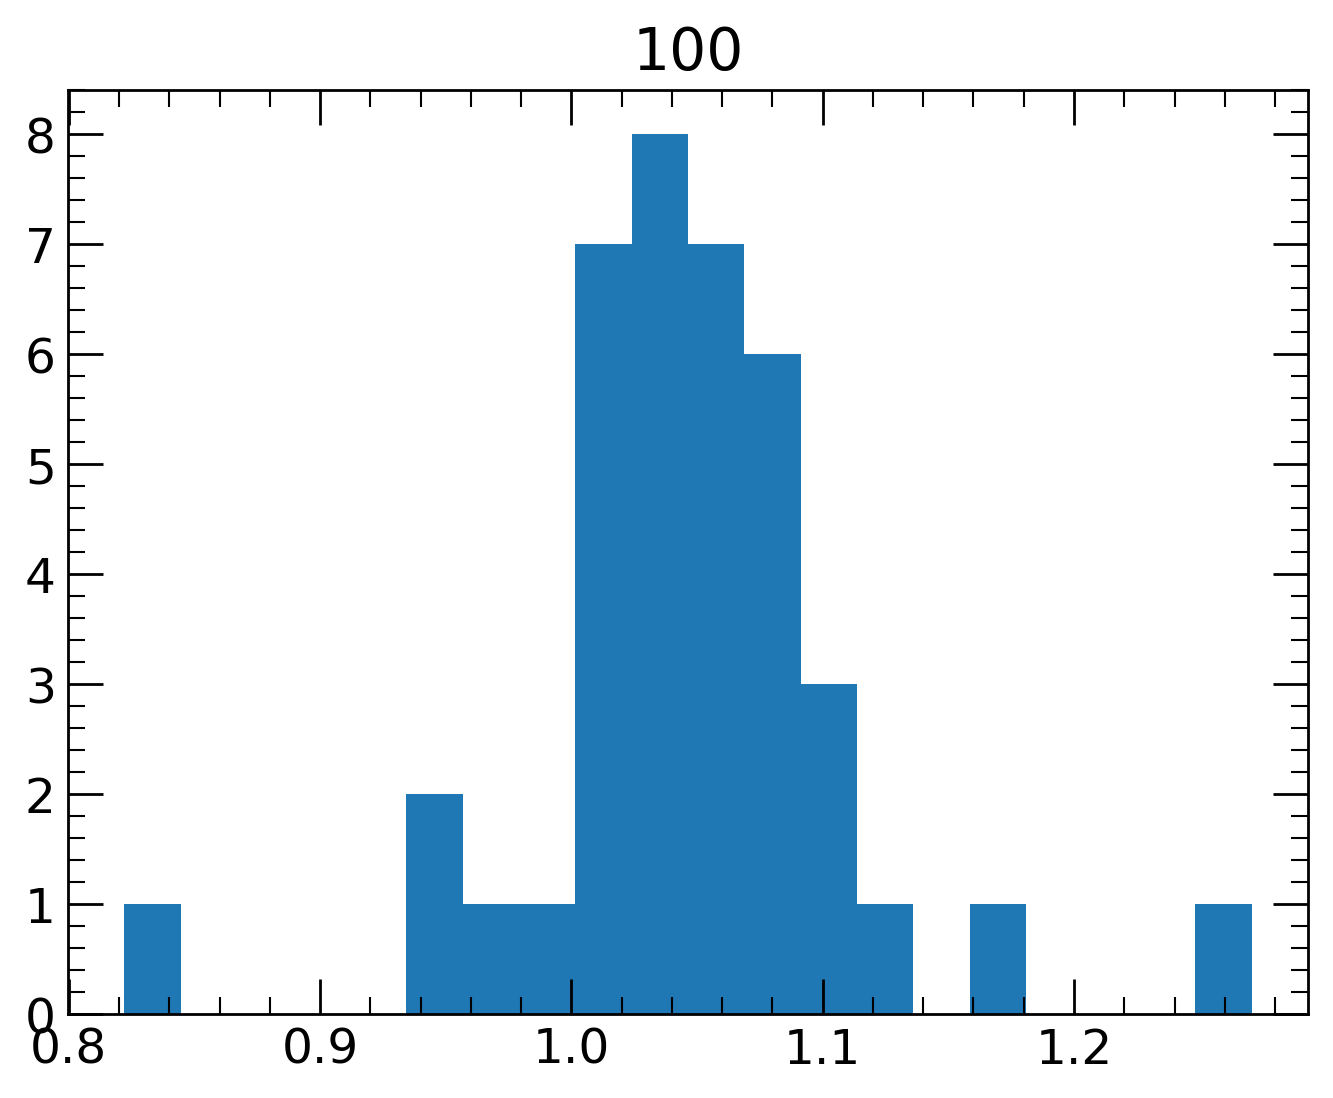

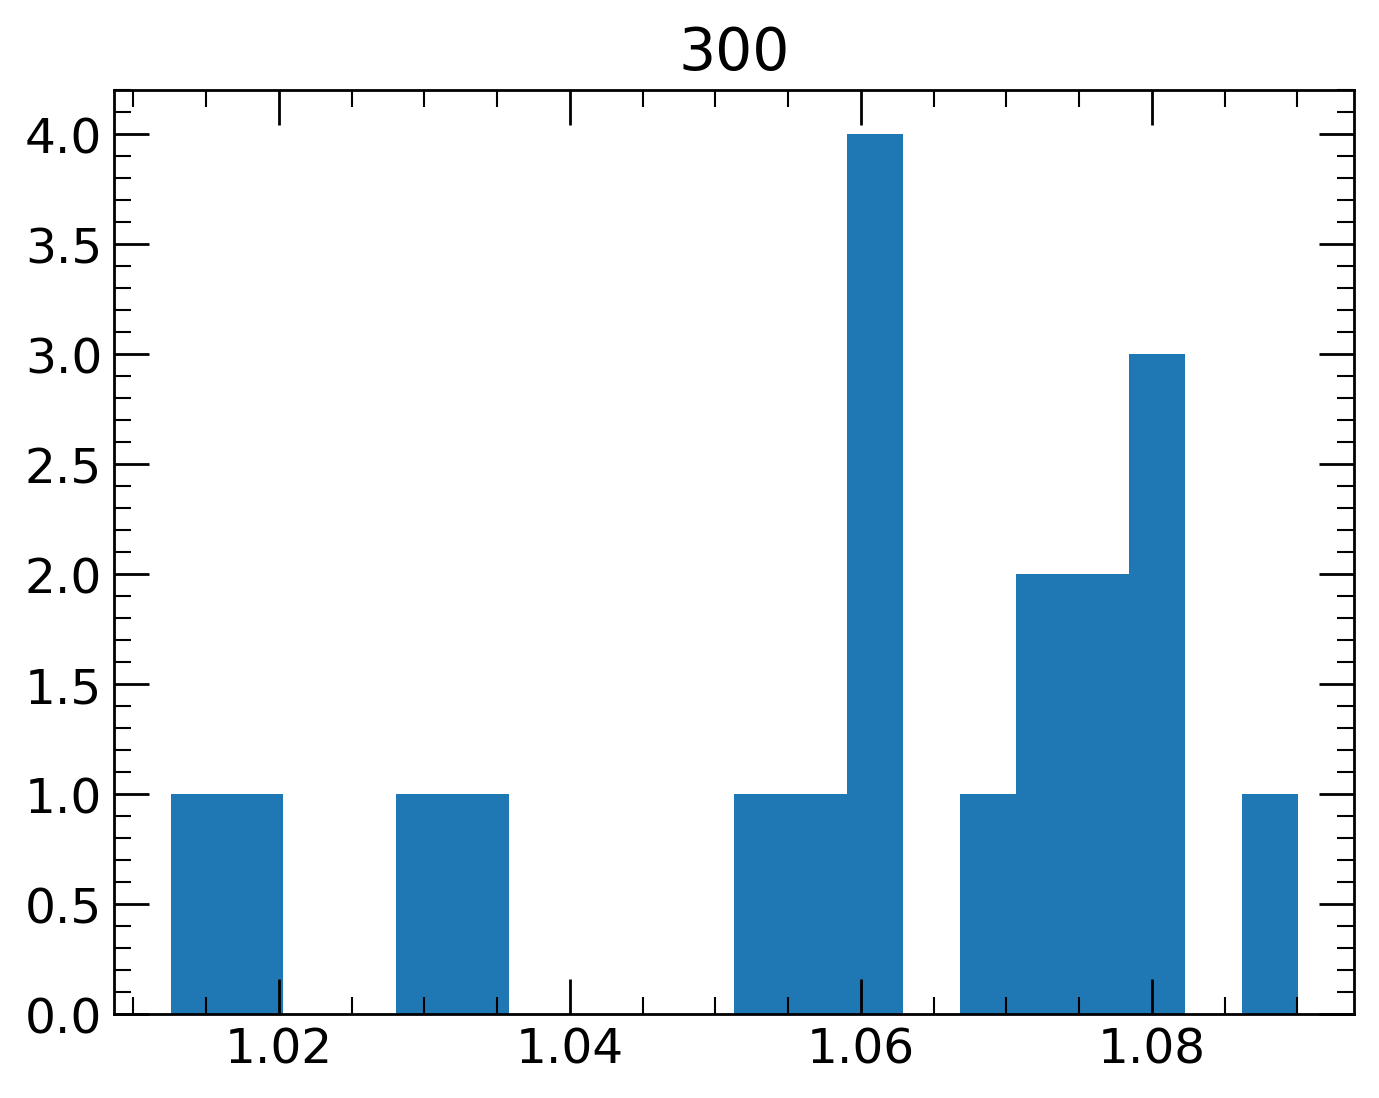

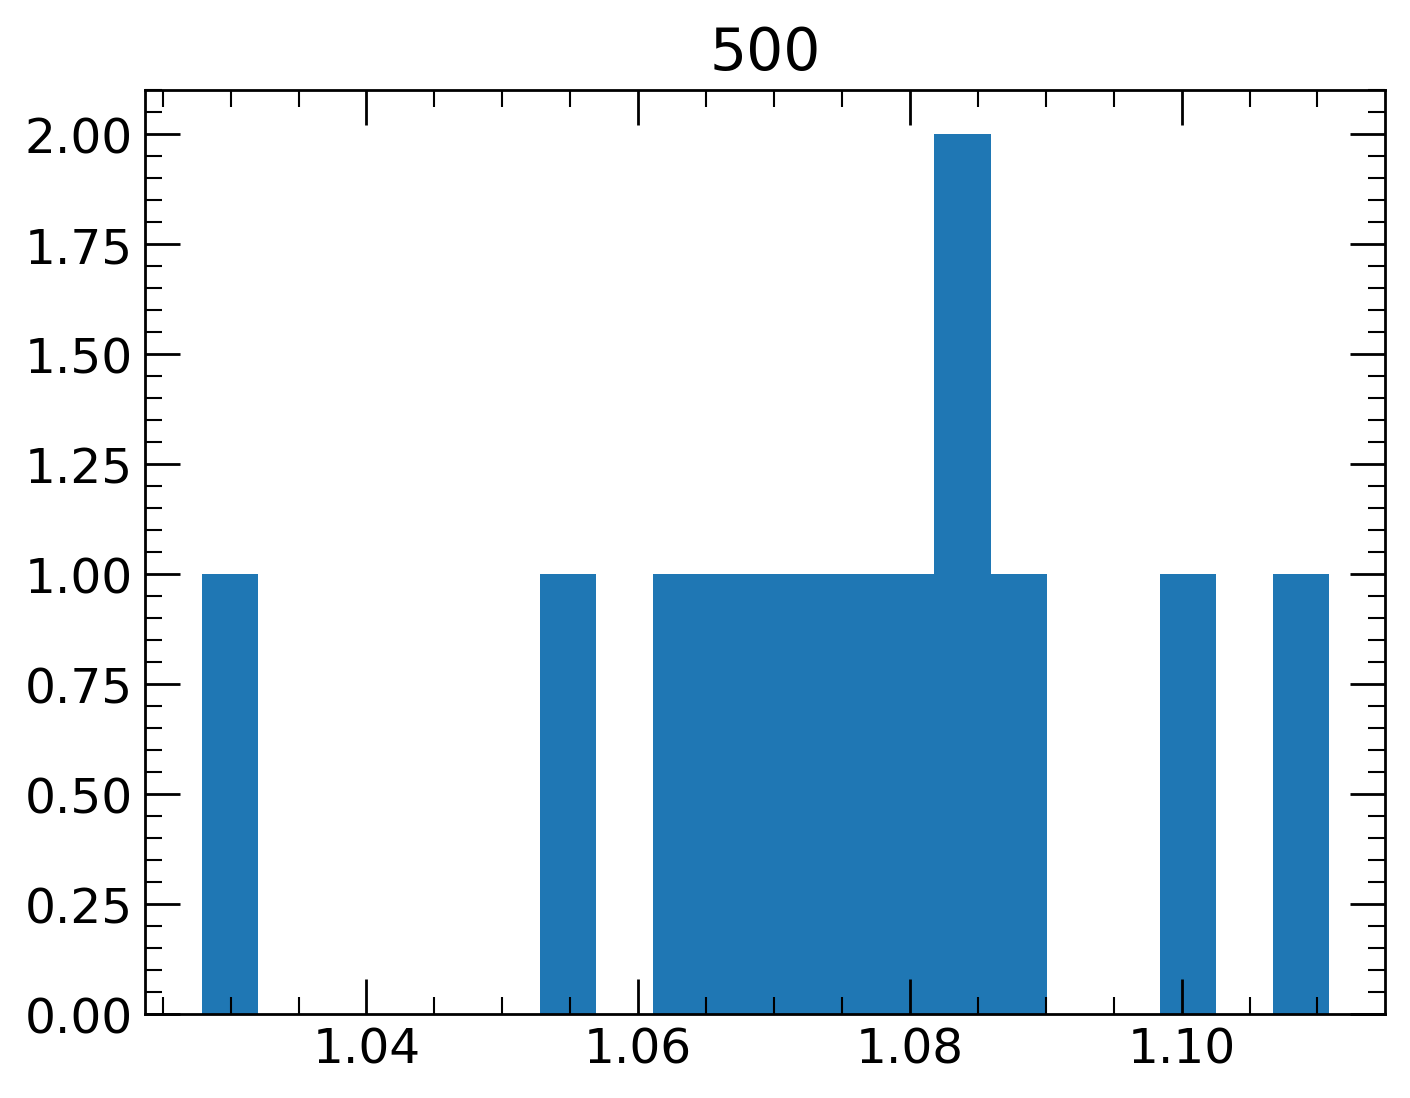

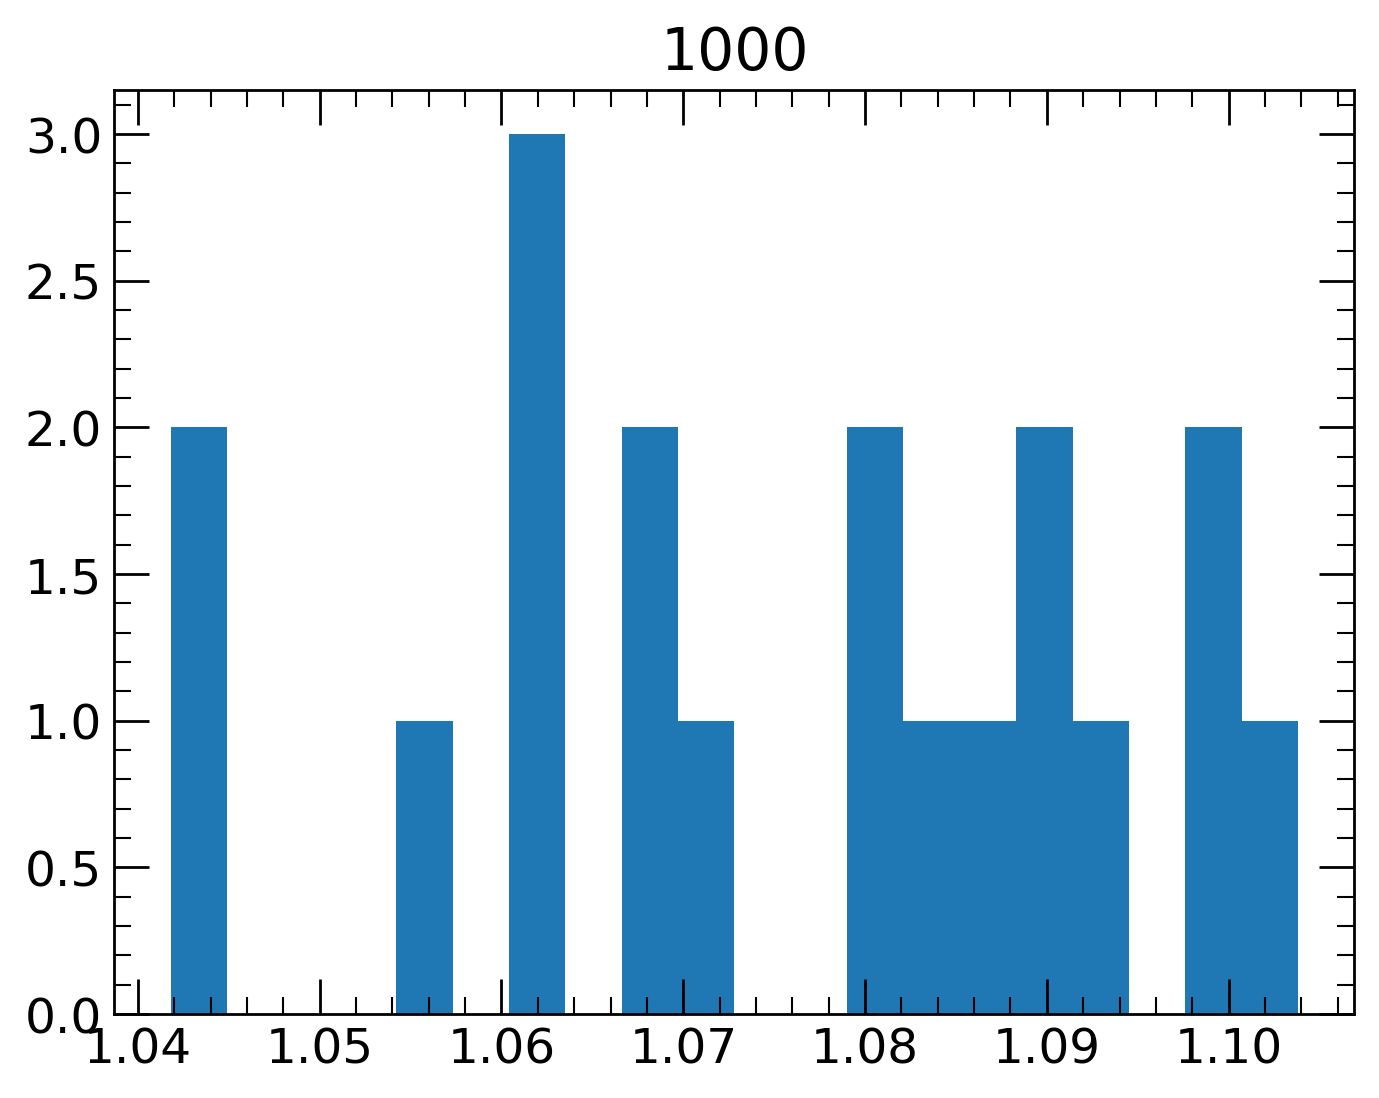

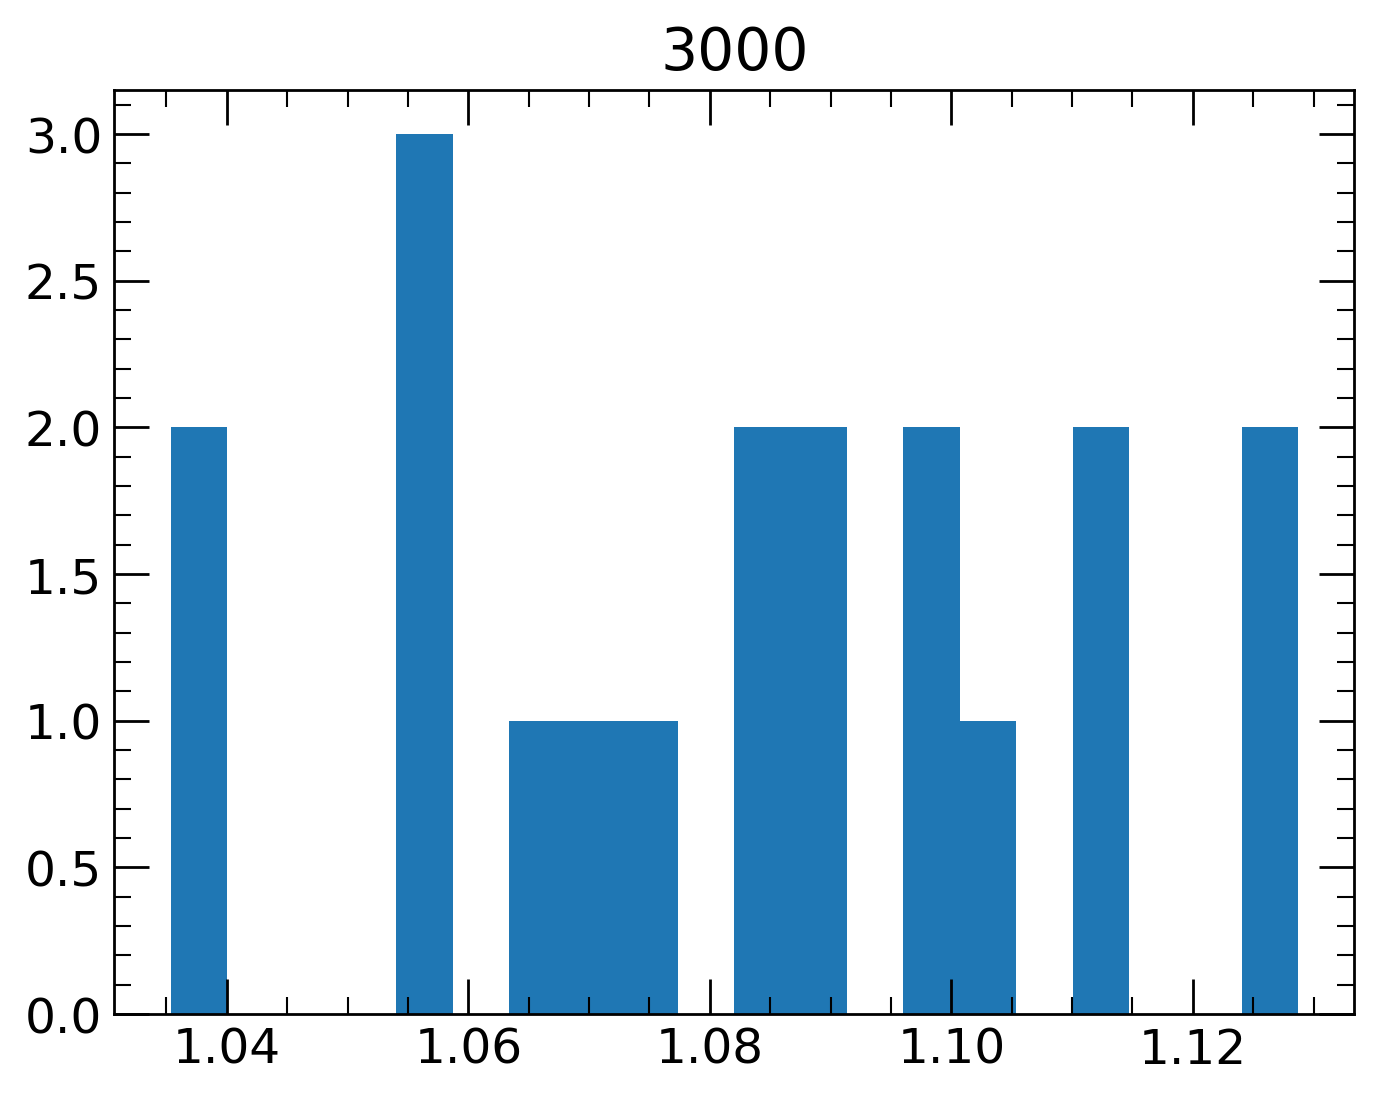

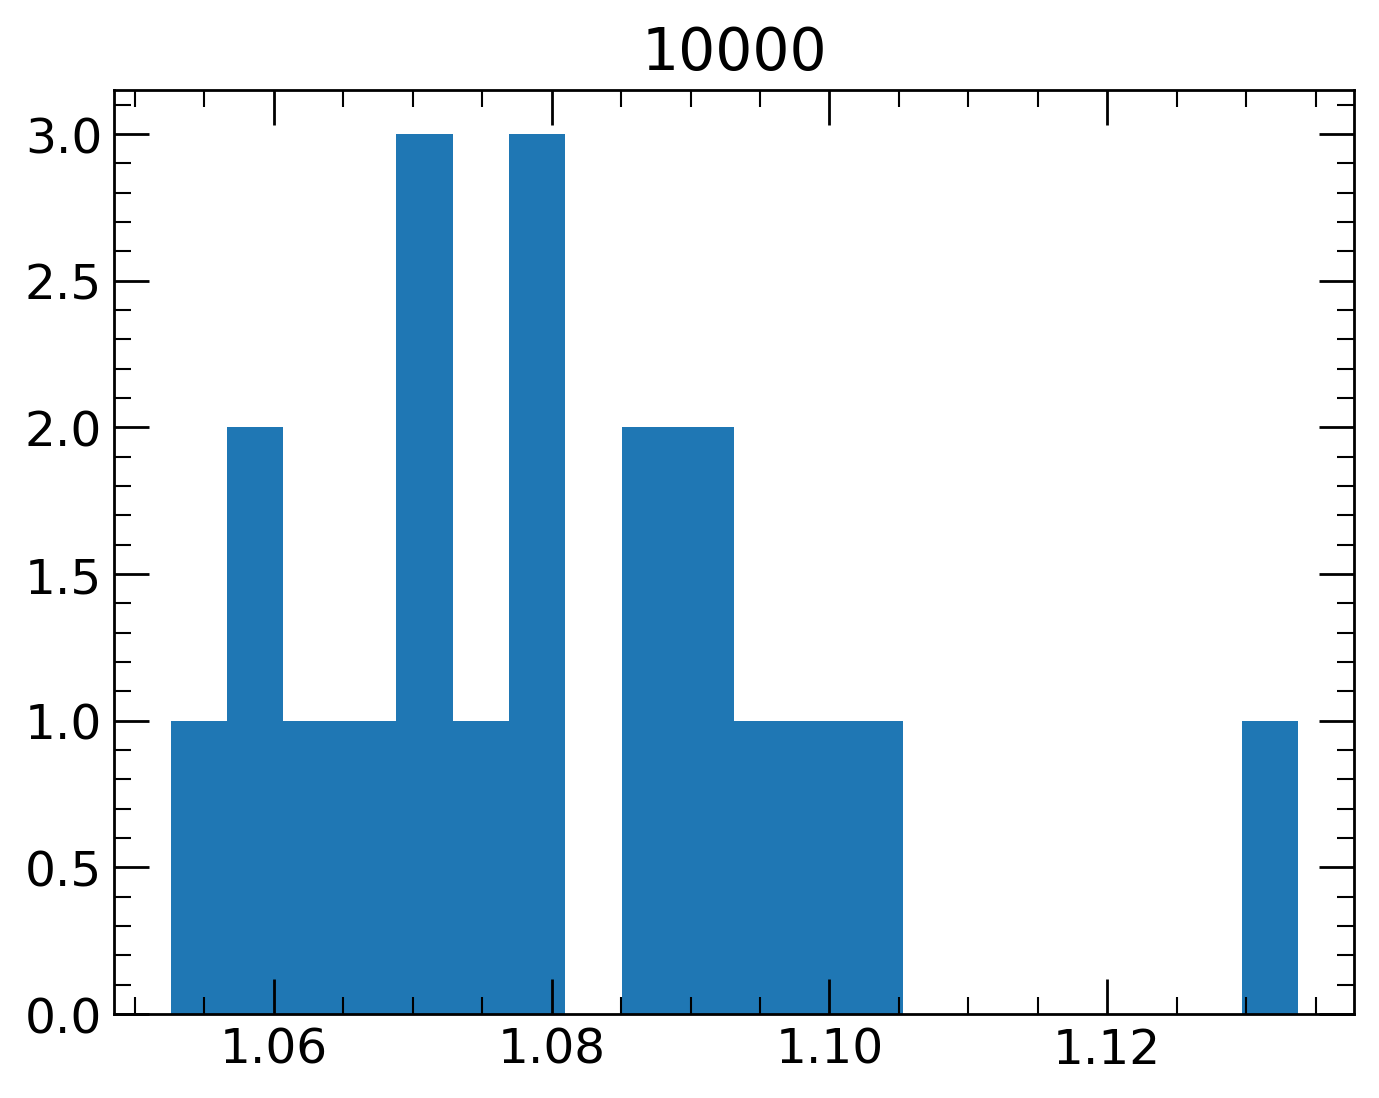

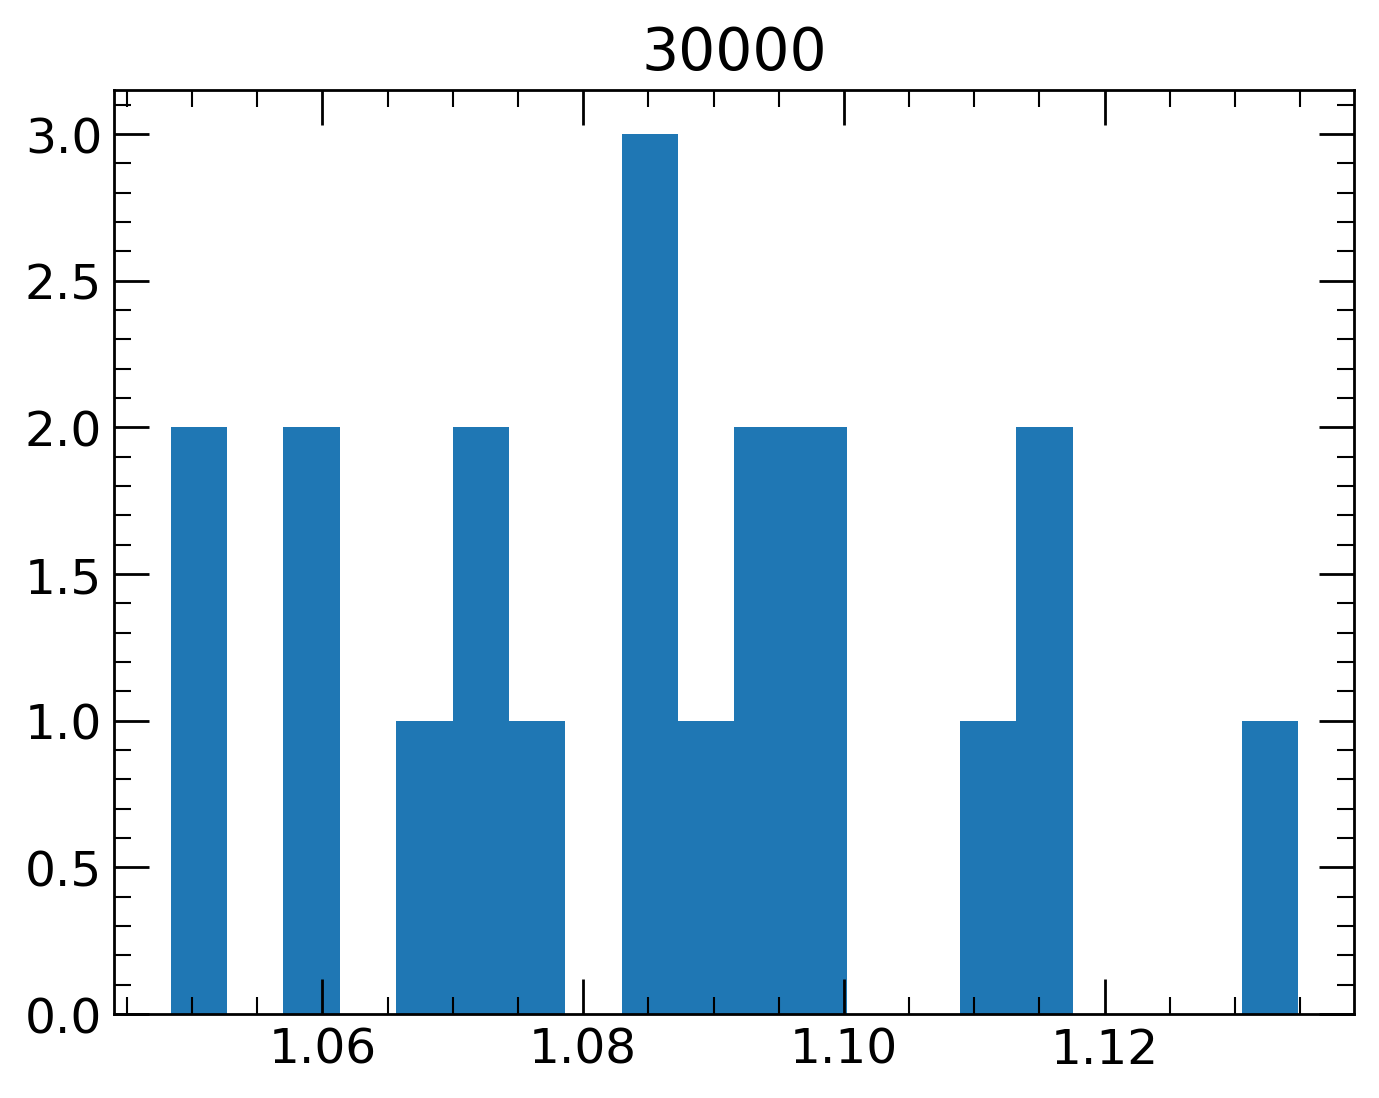

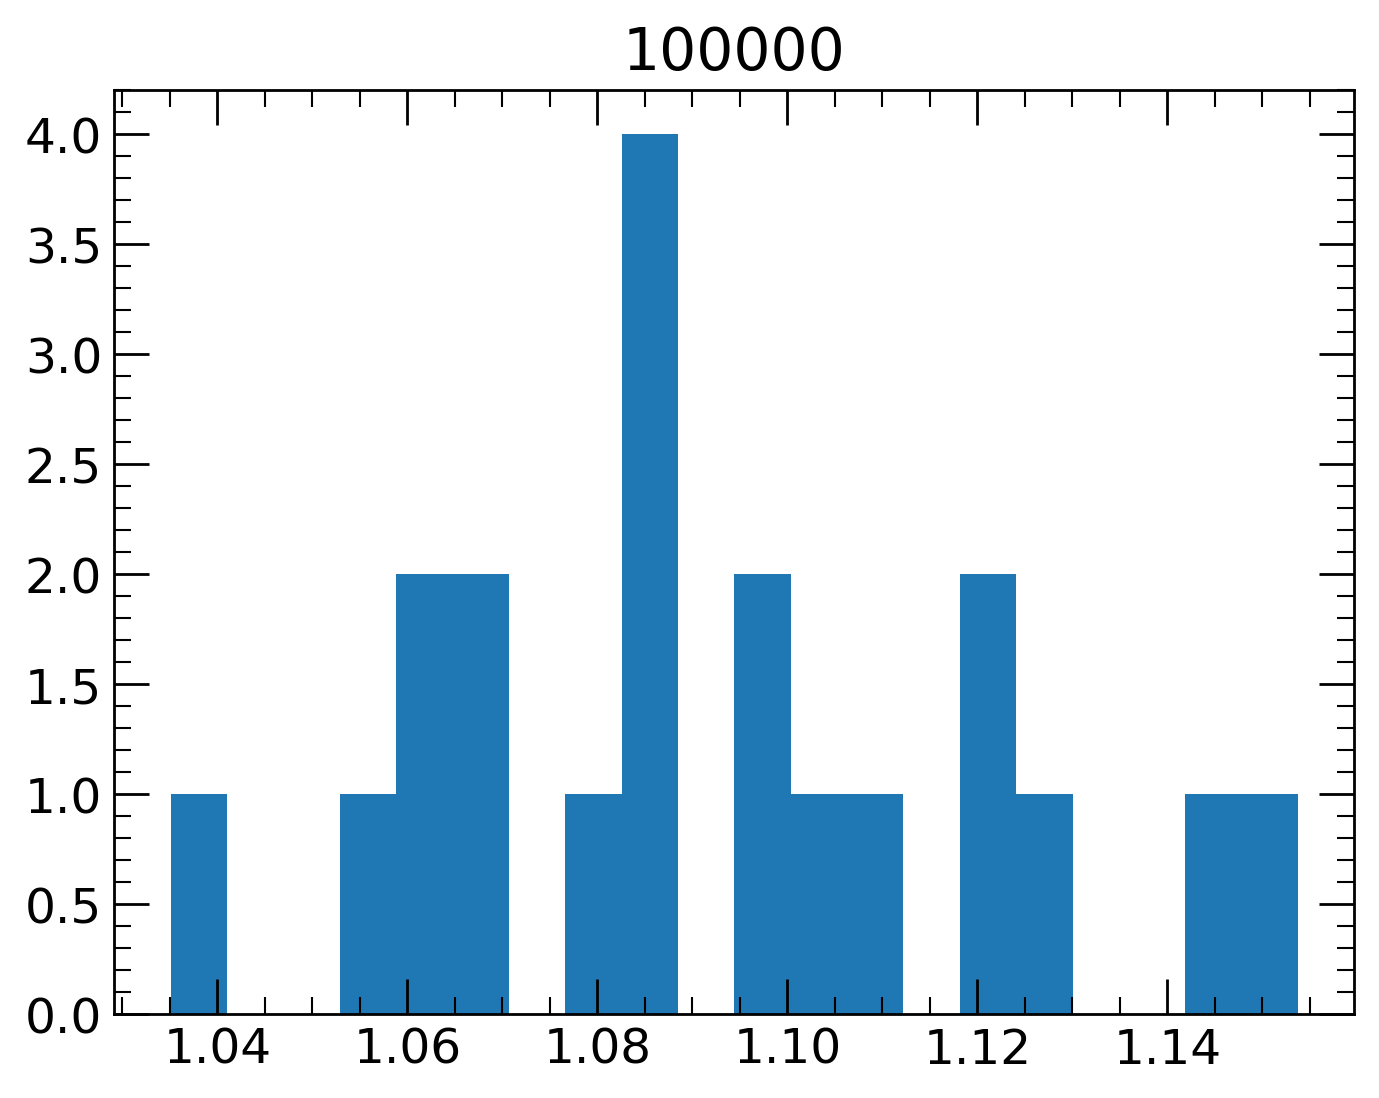

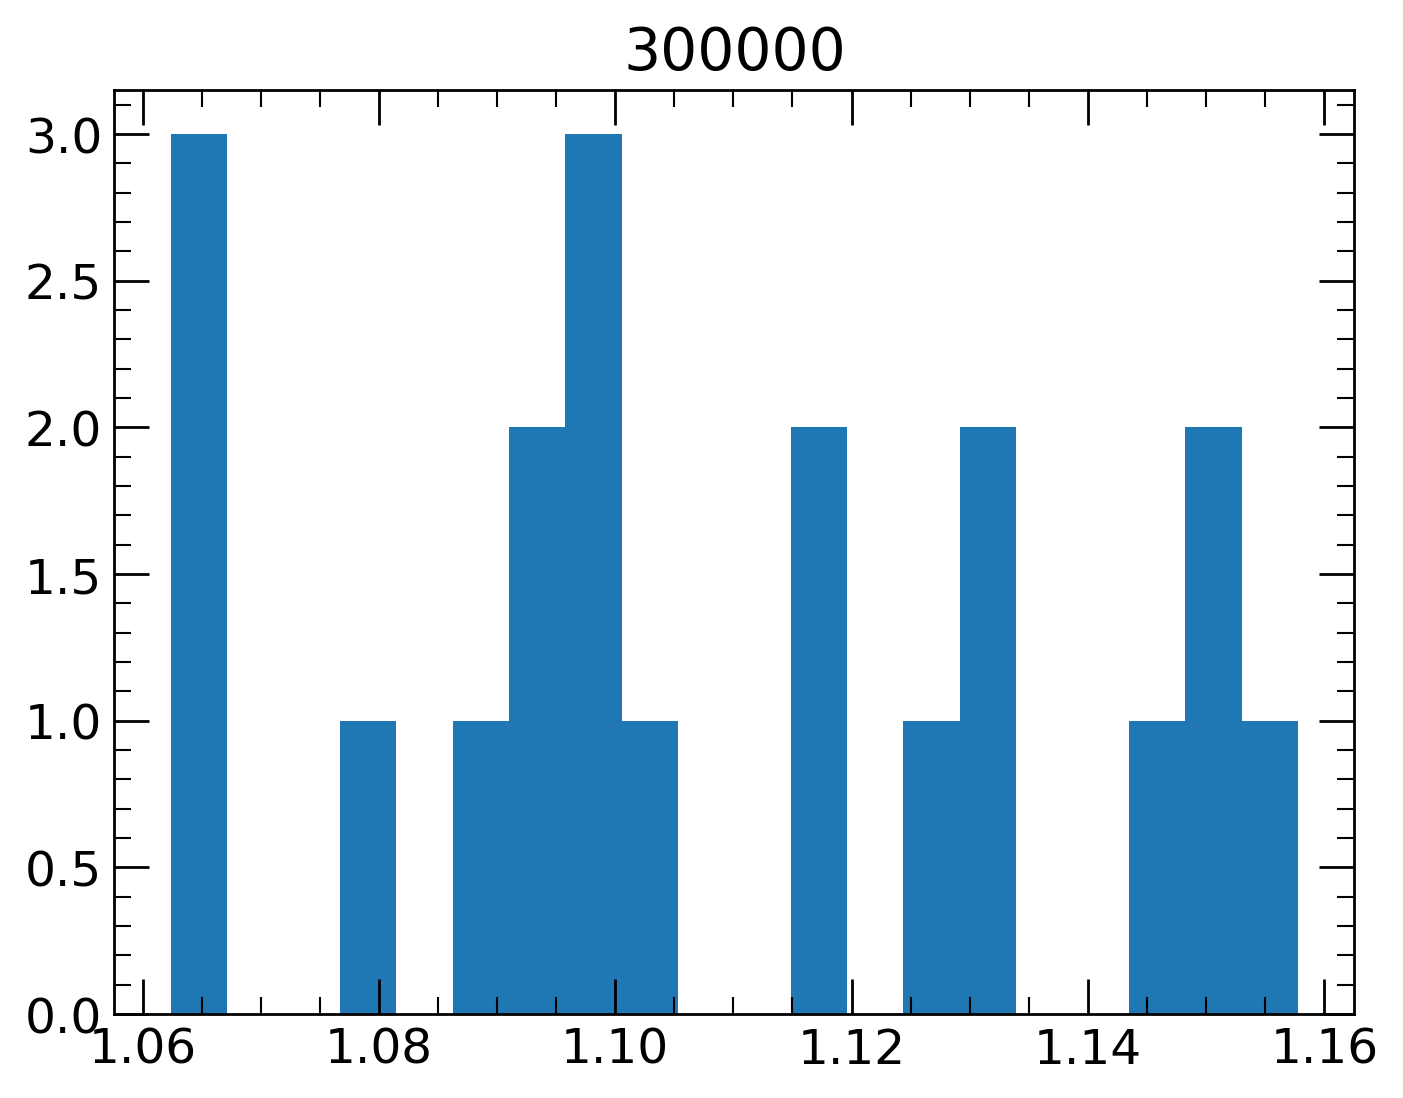

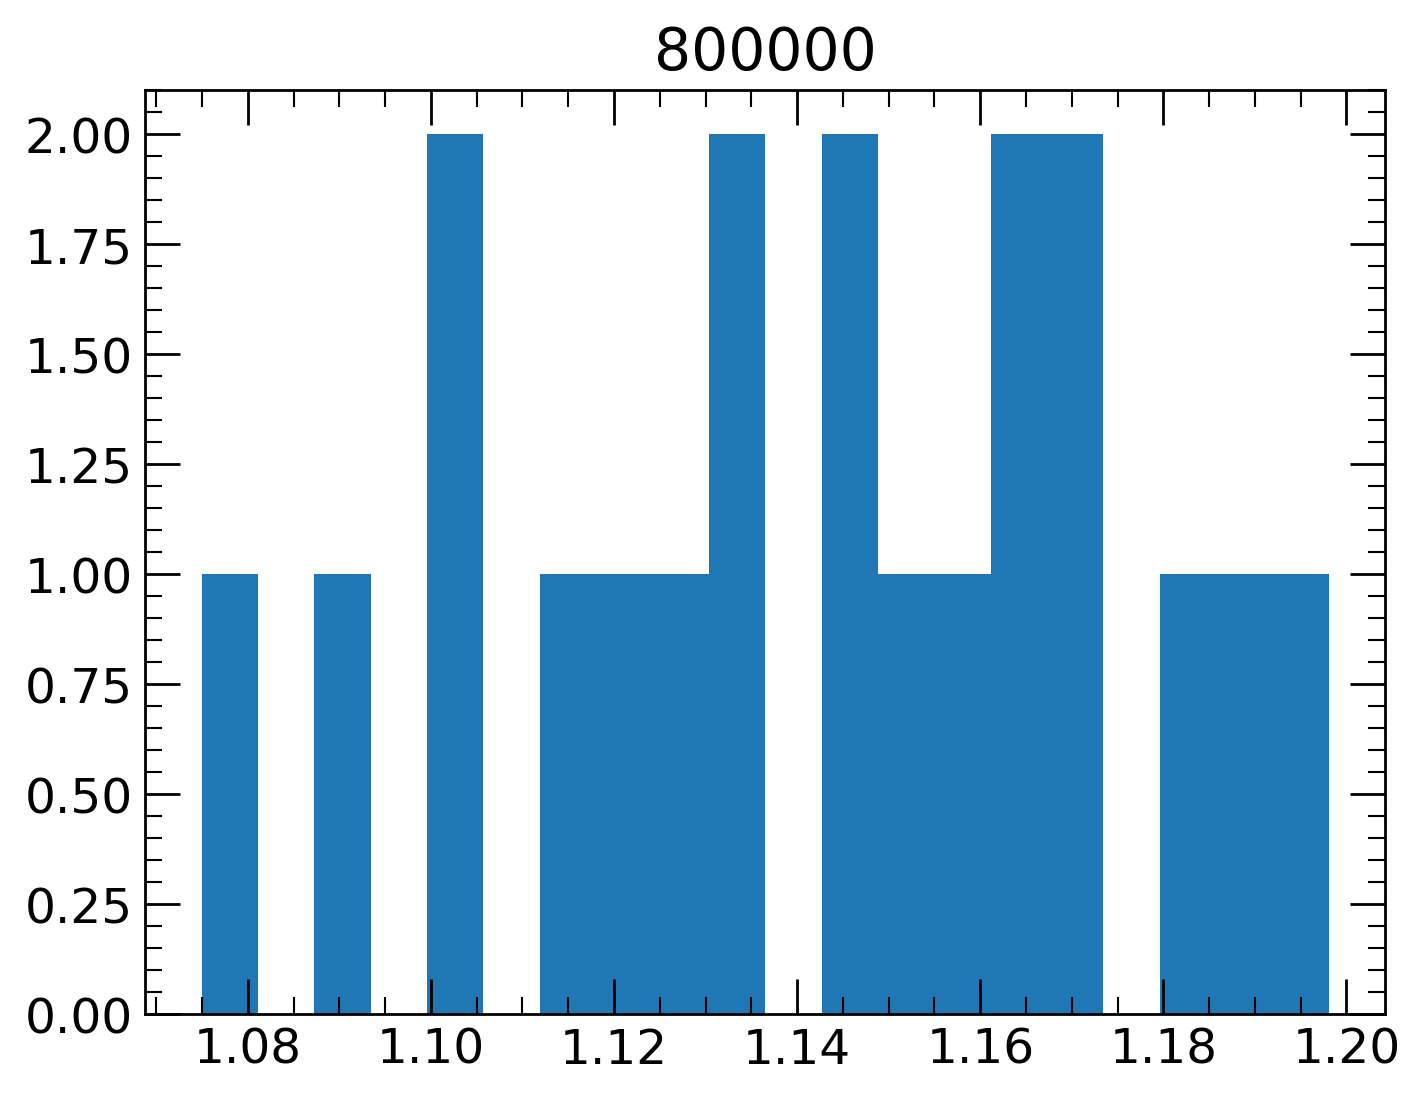

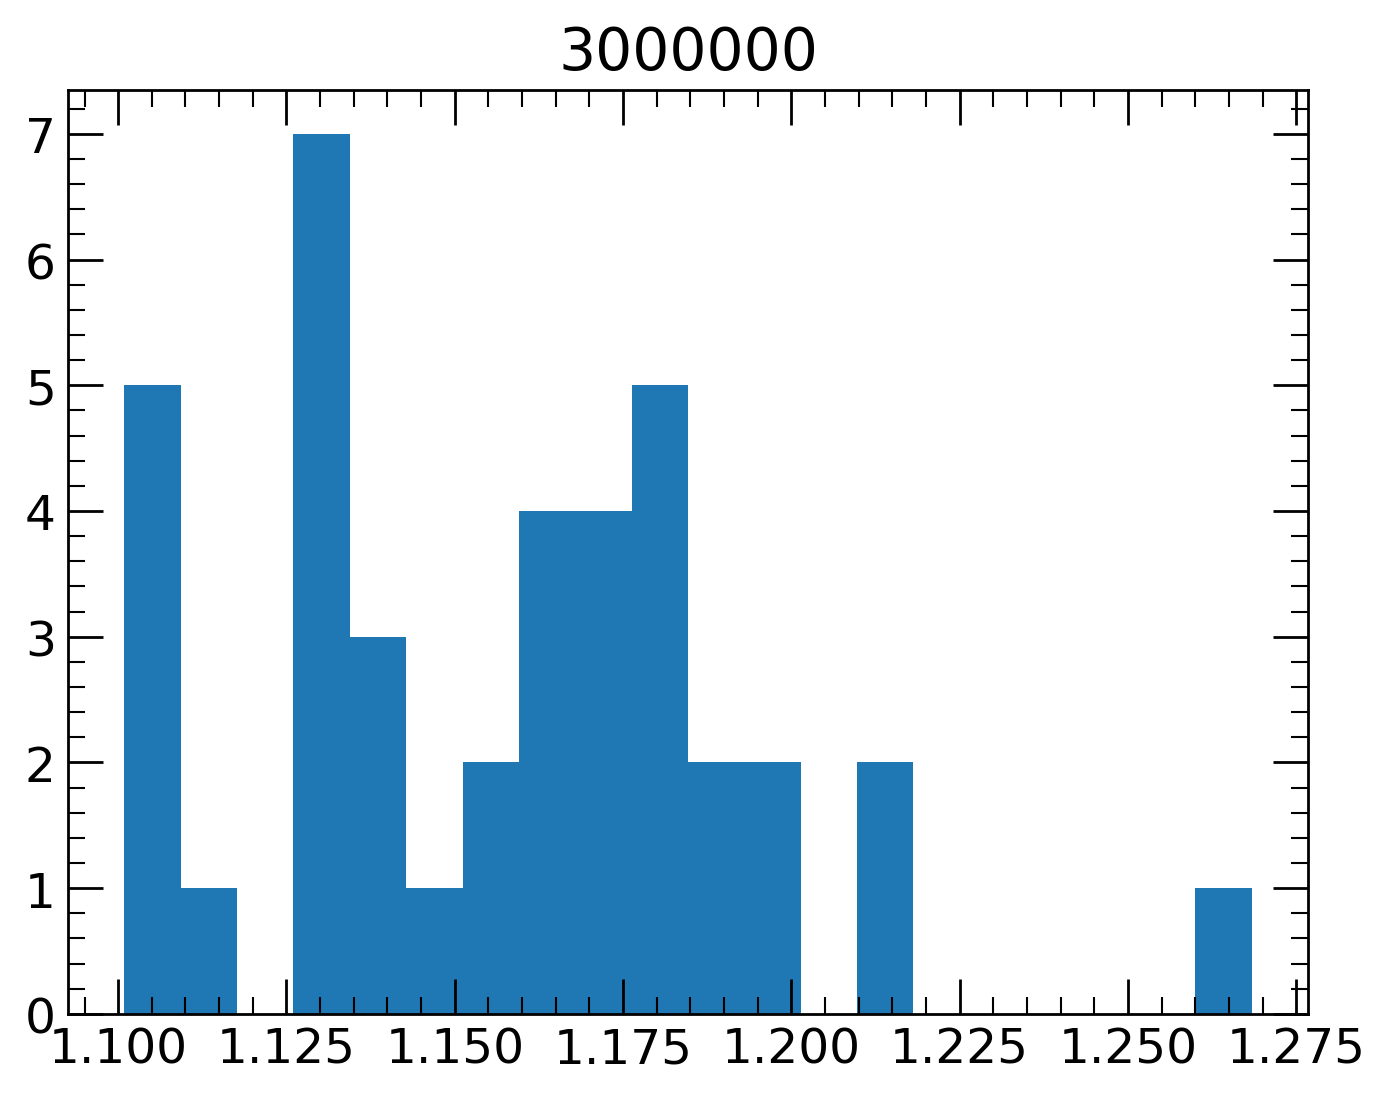

In [324]:
qkey=(0,0)
for delay in sorted(on_after_corrs_shot_avg[qkey].keys()):
    plt.figure()
    tu=plt.hist(on_after_corrs_shot_avg[qkey][delay],bins=20)
    plt.title(delay)

Use this cell if you want to plot the normalized difference between C(on,after) and C(after,after)

In [38]:
on_after_norm_corrs_diff_global_avg=dict.fromkeys(on_after_corrs_shot_avg.keys())
additional_rows=avg_TT.shape[0]-before_num-after_num-1
for key in on_after_corrs_shot_avg.keys():
    on_after_norm_corrs_diff_global_avg[key]=dict.fromkeys(on_after_corrs_shot_avg[key].keys())
for (qxoff,qyoff) in on_after_norm_corrs_diff_global_avg.keys():
    print('(qx offset,qy offset)=',(qxoff,qyoff))
    for delay in sorted(on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)].keys()):
        norm_diff=np.divide(
            np.subtract(
                after_after_avg_corrs[(qxoff,qyoff)][delay],on_after_corrs_shot_avg[(qxoff,qyoff)][delay]),
            after_after_avg_corrs[(qxoff,qyoff)][delay])
        norm_diff_var=(norm_diff**2)*(np.add(after_after_var_corrs[(qxoff,qyoff)][delay],on_after_corrs_shot_var[(qxoff,qyoff)][delay])/(norm_diff**2)+np.divide(after_after_var_corrs[(qxoff,qyoff)][delay],[after_after_avg_corrs[(qxoff,qyoff)][delay][k]**2 for k in range(len(after_after_avg_corrs[(qxoff,qyoff)][delay]))]))
        on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)][delay]={'mean':np.nanmean(norm_diff),'std err':len(after_after_avg_corrs[(qxoff,qyoff)][delay])**(-1.5)*np.sqrt(np.nansum(norm_diff_var))}
        print('Delay:',delay,'ns',on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)][delay])

        final_diff=np.divide(
            np.subtract(
                after_after_avg_corrs[(qxoff,qyoff)][delay],final_after_after_corrs_shot_avg[(qxoff,qyoff)][delay]),
            after_after_avg_corrs[(qxoff,qyoff)][delay])
        final_diff_var=(final_diff**2)*\
        (np.add(after_after_var_corrs[(qxoff,qyoff)][delay],final_after_after_corrs_shot_var[(qxoff,qyoff)][delay])\
         /(final_diff**2)+np.divide(after_after_var_corrs[(qxoff,qyoff)][delay],[after_after_avg_corrs[(qxoff,qyoff)][delay][k]**2 for k in range(len(after_after_avg_corrs[(qxoff,qyoff)][delay]))]))
        on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)][delay+25*3.33e7]={'mean':np.nanmean(final_diff),'std err':len(after_after_avg_corrs[(qxoff,qyoff)][delay])**(-1.5)*np.sqrt(np.nansum(final_diff_var))}
        print('Final shot corr difference',np.nanmean(final_diff))
         
        norm_diff_additional=[]
        norm_diff_var_additional=[]
        for j in range(additional_rows):
            add_delay=(j+1)*3.33e7
            norm_diff_add=np.divide(
                np.subtract(
                    after_after_avg_corrs[(qxoff,qyoff)][delay],additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay][:,j]),
                after_after_avg_corrs[(qxoff,qyoff)][delay])
            norm_diff_add_var=(norm_diff_add**2)*(np.add(after_after_var_corrs[(qxoff,qyoff)][delay],
                                                         additional_on_after_corrs_shot_var[(qxoff,qyoff)][delay][:,j])/(norm_diff_add**2)+np.divide(after_after_var_corrs[(qxoff,qyoff)][delay],
                                                                                                                                                     [after_after_avg_corrs[(qxoff,qyoff)][delay][k]**2 for k in range(len(after_after_avg_corrs[(qxoff,qyoff)][delay]))]))
            
            norm_diff_additional.append(norm_diff_add)
            norm_diff_var_additional.append(norm_diff_add_var)
            on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)][delay+add_delay]={'mean':np.nanmean(norm_diff_add),
                                                                                 'std err':len(after_after_avg_corrs[(qxoff,qyoff)][delay])**(-1.5)*np.sqrt(np.nansum(norm_diff_add_var))}
            
            print('Delay:',delay+add_delay,'ns',on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)][delay+add_delay])

        
            
        # norm_diff_66=np.divide(
        #     np.subtract(
        #         after_after_avg_corrs[(qxoff,qyoff)][delay],additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay][:,1]),
        #     after_after_avg_corrs[(qxoff,qyoff)][delay])
        # norm_diff_66_var=(norm_diff_66**2)*(np.add(after_after_var_corrs[(qxoff,qyoff)][delay],additional_on_after_corrs_shot_var[(qxoff,qyoff)][delay][:,1])/(norm_diff_66**2)+np.divide(after_after_var_corrs[(qxoff,qyoff)][delay],[after_after_avg_corrs[(qxoff,qyoff)][delay][k]**2 for k in range(len(after_after_avg_corrs[(qxoff,qyoff)][delay]))]))
        
        # on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)][delay+6.66e7]={'mean':np.nanmean(norm_diff_66),'std err':len(after_after_avg_corrs[(qxoff,qyoff)][delay])**(-1.5)*np.sqrt(np.nansum(norm_diff_66_var))}
    #     print(len(on_after_corrs_shot_avg[delay]),on_after_corrs_global_avg[delay])
        # print('Delay:',delay+6.66e7,'ns',on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)][delay+6.66e7])

(qx offset,qy offset)= (0, 0)
Delay: 100 ns {'mean': 0.11265861445230879, 'std err': 0.003801174133476633}
Final shot corr difference -0.0004698864094623525
Delay: 33300100.0 ns {'mean': 0.010492979321946675, 'std err': 0.0016170522383367914}
Delay: 66600100.0 ns {'mean': 0.003657120858738756, 'std err': 0.001615390299389921}
Delay: 99900100.0 ns {'mean': -0.0006951231685221577, 'std err': 0.0016139993906698277}
Delay: 133200100.0 ns {'mean': -0.0019966926582647097, 'std err': 0.0016679003619384256}
Delay: 166500100.0 ns {'mean': 0.0053526109813133846, 'std err': 0.0016160004629466697}
Delay: 199800100.0 ns {'mean': -0.002608643474689909, 'std err': 0.0016453613433668017}
Delay: 233100100.0 ns {'mean': 0.0018051789916898667, 'std err': 0.0016496371944787795}
Delay: 266400100.0 ns {'mean': -0.007769729682673676, 'std err': 0.0016669895721862793}
Delay: 300 ns {'mean': 0.09844349944176678, 'std err': 0.0032657468427683446}
Final shot corr difference 0.002270120965408016
Delay: 33300300.0

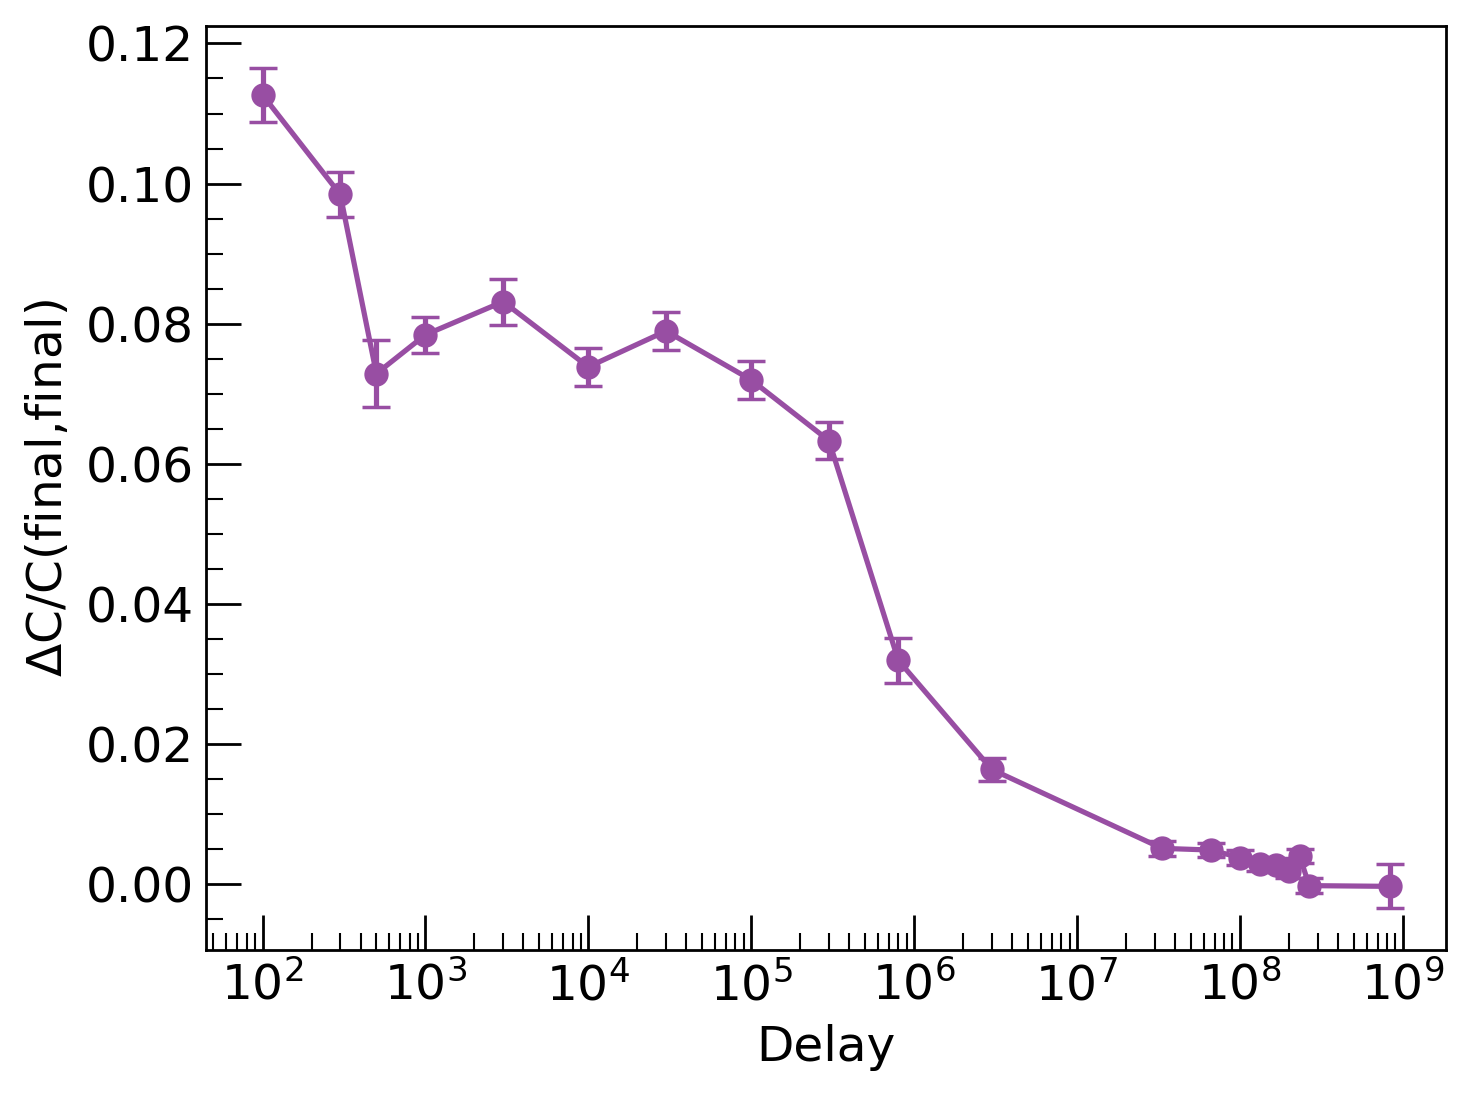

In [40]:
plt.figure()
colors=pylab.cm.brg(np.linspace(0,1,len(on_after_norm_corrs_diff_global_avg.keys())))
for ind,(qxoff,qyoff) in enumerate(on_after_norm_corrs_diff_global_avg.keys()):
    delays_raw,corr_means_raw,corr_stds_raw=plottable_lists_from_meanstd_dict(on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)])
    delays_raw=np.array(delays_raw)
    corr_means_raw=np.array(corr_means_raw)
    corr_stds_raw=np.array(corr_stds_raw)
    beginning_inds=delays_raw<3.33e7
    end_inds=delays_raw>8e8
    delays=np.concatenate((delays_raw[beginning_inds],np.array(additional_delays),np.array([25*3.33e7])))
    corr_means_additional=[]
    corr_stds_additional=[]
    for add_delay in additional_delays:
        inds_add=np.logical_and(delays_raw>add_delay,delays_raw<add_delay+3.33e7)
        corr_means_additional.append(np.mean(corr_means_raw[inds_add]))
        corr_stds_additional.append(np.sqrt(np.sum(np.array(corr_stds_raw[inds_add])**2))/np.sum(inds_add))
    corr_means=np.concatenate((corr_means_raw[beginning_inds],np.array(corr_means_additional),[np.mean(corr_means_raw[end_inds])]))
    corr_stds=np.concatenate((corr_stds_raw[beginning_inds],np.array(corr_stds_additional),[np.mean(corr_stds_raw[end_inds])]))
    plt.errorbar(delays,corr_means,yerr=corr_stds,fmt='o-',capsize=4,label=str((qxoff,qyoff)),color='#984ea3')
    # plt.errorbar(delays_raw,corr_means_raw,yerr=corr_stds_raw,fmt='o-',capsize=4,label=str((qxoff,qyoff)),color=colors[ind])
    #     plt.plot(delays,corr_means,'o-',label=str((qxoff,qyoff)),color=colors[ind])
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Delay')
    plt.ylabel('$\Delta$C/C(final,final)')
    # plt.xlim([30,1.1e8])
    # plt.xticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8],
    #            labels=['100 ns',r'1 $\mu$s',r'10 $\mu$s',r'100 $\mu$s','1 ms','10 ms','100 ms'],
    #           rotation=45)
    plt.tick_params('both',which='both',right=False,top=False)
    plt.tick_params('both',which='minor',length=5)
    # plt.ylim([0,0.12])
    # plt.xlim([3.32e7,3.37e7])
    # plt.xlim([6.6595e7,6.662e7])
#     plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference.png'.format(detector)))
# plt.legend(bbox_to_anchor=(1,1))
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_Sutton.svg'.format(detector,ROI_size)))
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_NormedSuttonStd.svg'.format(detector,ROI_size)))

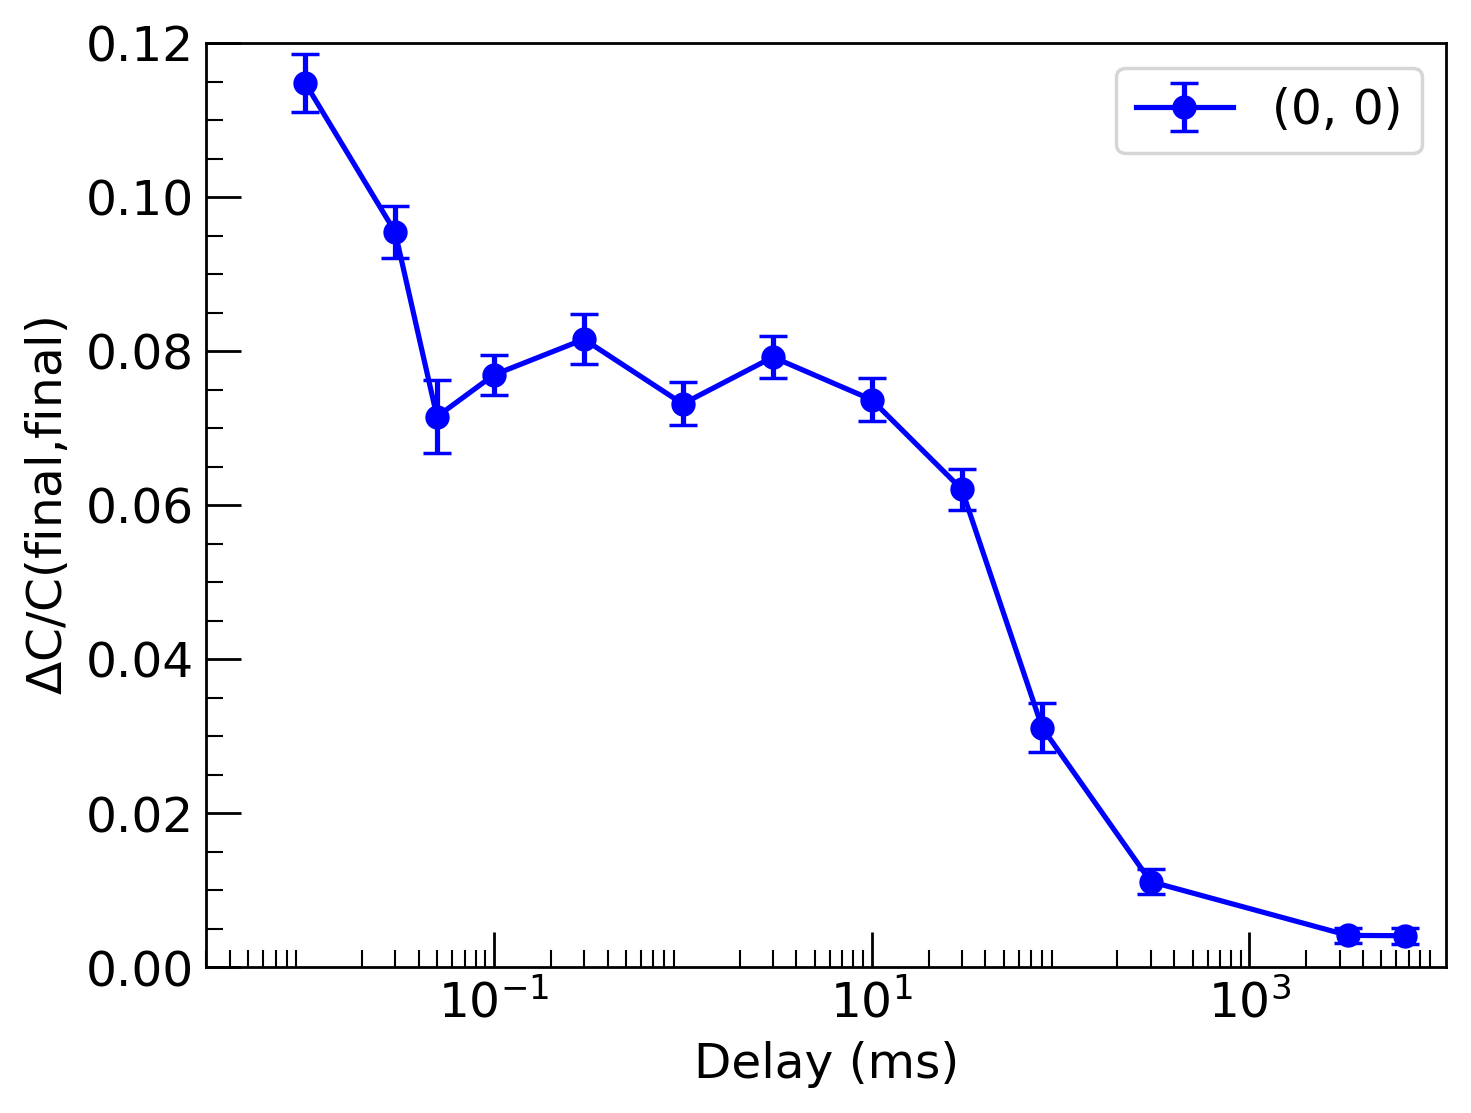

In [55]:
plt.figure()
colors=pylab.cm.brg(np.linspace(0,1,len(on_after_norm_corrs_diff_global_avg.keys())))
for ind,(qxoff,qyoff) in enumerate(on_after_norm_corrs_diff_global_avg.keys()):
    delays_raw,corr_means_raw,corr_stds_raw=plottable_lists_from_meanstd_dict(on_after_norm_corrs_diff_global_avg[(qxoff,qyoff)])
    delays_raw=np.array(delays_raw)
    corr_means_raw=np.array(corr_means_raw)
    corr_stds_raw=np.array(corr_stds_raw)
    inds_33=np.logical_and(delays_raw>3.33e7,delays_raw<3.33e7+4e6)
    inds_66=np.logical_and(delays_raw>6.66e7,delays_raw<6.66e7+4e6)
    beginning_inds=np.logical_not(np.logical_or(inds_33,inds_66))
    delays=np.array([*delays_raw[beginning_inds],3.33e7,6.66e7])
    sorted_inds=np.argsort(delays)
    corr_means=np.array([*corr_means_raw[beginning_inds],np.mean(corr_means_raw[inds_33]),np.mean(corr_means_raw[inds_66])])
    corr_stds=np.array([*corr_stds_raw[beginning_inds],np.sqrt(np.sum(np.array(corr_stds_raw[inds_33])**2))/np.sum(inds_33),np.sqrt(np.sum(np.array(corr_stds_raw[inds_66])**2))/np.sum(inds_66)])
    plt.errorbar(delays[sorted_inds],corr_means[sorted_inds],yerr=corr_stds[sorted_inds],fmt='o-',capsize=4,label=str((qxoff,qyoff)),color=colors[ind])
    # plt.errorbar(delays_raw,corr_means_raw,yerr=corr_stds_raw,fmt='o-',capsize=4,label=str((qxoff,qyoff)),color=colors[ind])
    #     plt.plot(delays,corr_means,'o-',label=str((qxoff,qyoff)),color=colors[ind])
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Delay (ms)')
    plt.ylabel('$\Delta$C/C(final,final)')
    plt.xlim([30,1.1e8])
    # plt.xticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8])
    plt.xticks([1e3,1e5,1e7],labels=[r'$10^{-1}$',r'$10^{1}$',r'$10^{3}$'])
    # plt.xticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8],
    #            labels=['100 ns',r'1 $\mu$s',r'10 $\mu$s',r'100 $\mu$s','1 ms','10 ms','100 ms'],
    #           rotation=45)
    plt.tick_params('both',which='both',right=False,top=False)
    plt.tick_params('both',which='minor',length=5)
    plt.ylim([0,0.12])
    # plt.xlim([3.32e7,3.37e7])
    # plt.xlim([6.6595e7,6.662e7])
#     plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference.png'.format(detector)))
plt.legend(bbox_to_anchor=(1,1))
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_Sutton_ROI-comp_zoom.svg'.format(detector,ROI_size)))
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_NormedSuttonStd.svg'.format(detector,ROI_size)))

run the following cell to save deltaC/C separately

In [42]:
diffC_data={'delays':delays,'corr means':corr_means, 'corr err':corr_stds}
print(diffC_data)

{'delays': array([1.000e+02, 3.000e+02, 5.000e+02, 1.000e+03, 3.000e+03, 1.000e+04,
       3.000e+04, 1.000e+05, 3.000e+05, 8.000e+05, 3.000e+06, 3.330e+07,
       6.660e+07, 9.990e+07, 1.332e+08, 1.665e+08, 1.998e+08, 2.331e+08,
       2.664e+08, 8.325e+08]), 'corr means': array([ 0.11265861,  0.0984435 ,  0.07286966,  0.07841943,  0.0831484 ,
        0.07383586,  0.07895674,  0.07197613,  0.06331504,  0.03194963,
        0.01637806,  0.00511542,  0.00487383,  0.00379684,  0.00289543,
        0.00280142,  0.00182907,  0.00397949, -0.00020477, -0.00030974]), 'corr err': array([0.00380117, 0.00326575, 0.00476052, 0.00257169, 0.00328292,
       0.00276235, 0.00269596, 0.00273936, 0.00265151, 0.00316324,
       0.00158277, 0.00102151, 0.0010203 , 0.00101771, 0.00101824,
       0.00100029, 0.00100866, 0.00101087, 0.00101762, 0.00312539])}


load single simulation to compare to

In [183]:
# sim_source='cell-auto-sims/log-early-time-tests/include-growth/scaled-t/1000nucs_500size_51growth-scaled-time-1.58E-02rate-markov-poisson_51anneal_hard/tau5.00E+05-exp-anneal_bound5.0E-02-1.0E-02-ave10'
# sim_source='cell-auto-sims/log-early-time-tests/include-growth/scaled-t/1000nucs_500size_51growth-scaled-time-1.58E-02rate-markov-poisson_51anneal_hard/alpha0.75_tau1.50E+05-longtail-anneal_bound5.0E-02-1.0E-02-ave250'
# sim_source='/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/log-time-early-test/include-growth/scaled-t/1000nucs_500size_51growth-scaled-time-1.58E-02rate-markov-poisson_51anneal_hard/alpha0.50_tau1.50E+05-longtail-anneal_bound5.0E-02-1.0E-02-ave250'
# sim_source='/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/'+\
# 'log-time-early-test/include-growth/scaled-t/'+\
# '1000nucs_500size_51growth-scaled-time-1.58E-02rate-markov-poisson_51anneal_hard/'+\
# 'alpha0.75_tau1.50E+05-longtail-anneal_bound5.0E-02-1.0E-02-ave250'
# sim_source='/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/'+\
# 'log-time-early-test/include-growth/scaled-t/'+\
# '1000nucs_500size_51growth-scaled-time-1.58E-02rate-markov-poisson_51anneal_hard/'+\
# 'alpha0.85_tau1.50E+05-longtail-anneal_bound5.0E-02-1.0E-02-ave250'
sim_source='/cds/home/m/mangu2/Documents/Phase Change XCS Model/'+\
             'cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp/'+\
             '1000nucs_500size_51growth-scaled-time-1.58E-02rate-markov-poisson_51anneal_hard/'+\
             'alpha0.98_tau1.50E+05-longtail-anneal_bound5.0E-02-1.0E-02-ave250'
# sim_source='/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/'+\
# 'log-time-early-test/include-growth/scaled-t/'+\
# '1000nucs_500size_51growth-scaled-time-1.58E-02rate-markov-poisson_51anneal_hard/'+\
# 'alpha0.95_tau1.50E+05-longtail-anneal_bound5.0E-02-1.0E-02-ave10'
data=np.load(os.path.join(sim_source,'multi_average_arrays_w-area0.npz'))
# data=np.load(os.path.join(sim_source,'multi_average_arrays_w-area0.npz'))
# data=np.load(os.path.join(sim_source,'multi_average_arrays_w-area0.npz'))
extended_timeSteps=np.array([0,*data['timeSteps']])
ROI=0
raw_corrs=data['corr_funcs'][:,:,ROI]
avg_corr=np.mean(raw_corrs,axis=0)
corr_differential=-avg_corr/avg_corr[-1]+1
plt.figure()
plt.semilogx(extended_timeSteps,corr_differential,'.')

FileNotFoundError: [Errno 2] No such file or directory: '/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp/1000nucs_500size_51growth-scaled-time-1.58E-02rate-markov-poisson_51anneal_hard/alpha0.98_tau1.50E+05-longtail-anneal_bound5.0E-02-1.0E-02-ave250\\multi_average_arrays_w-area0.npz'

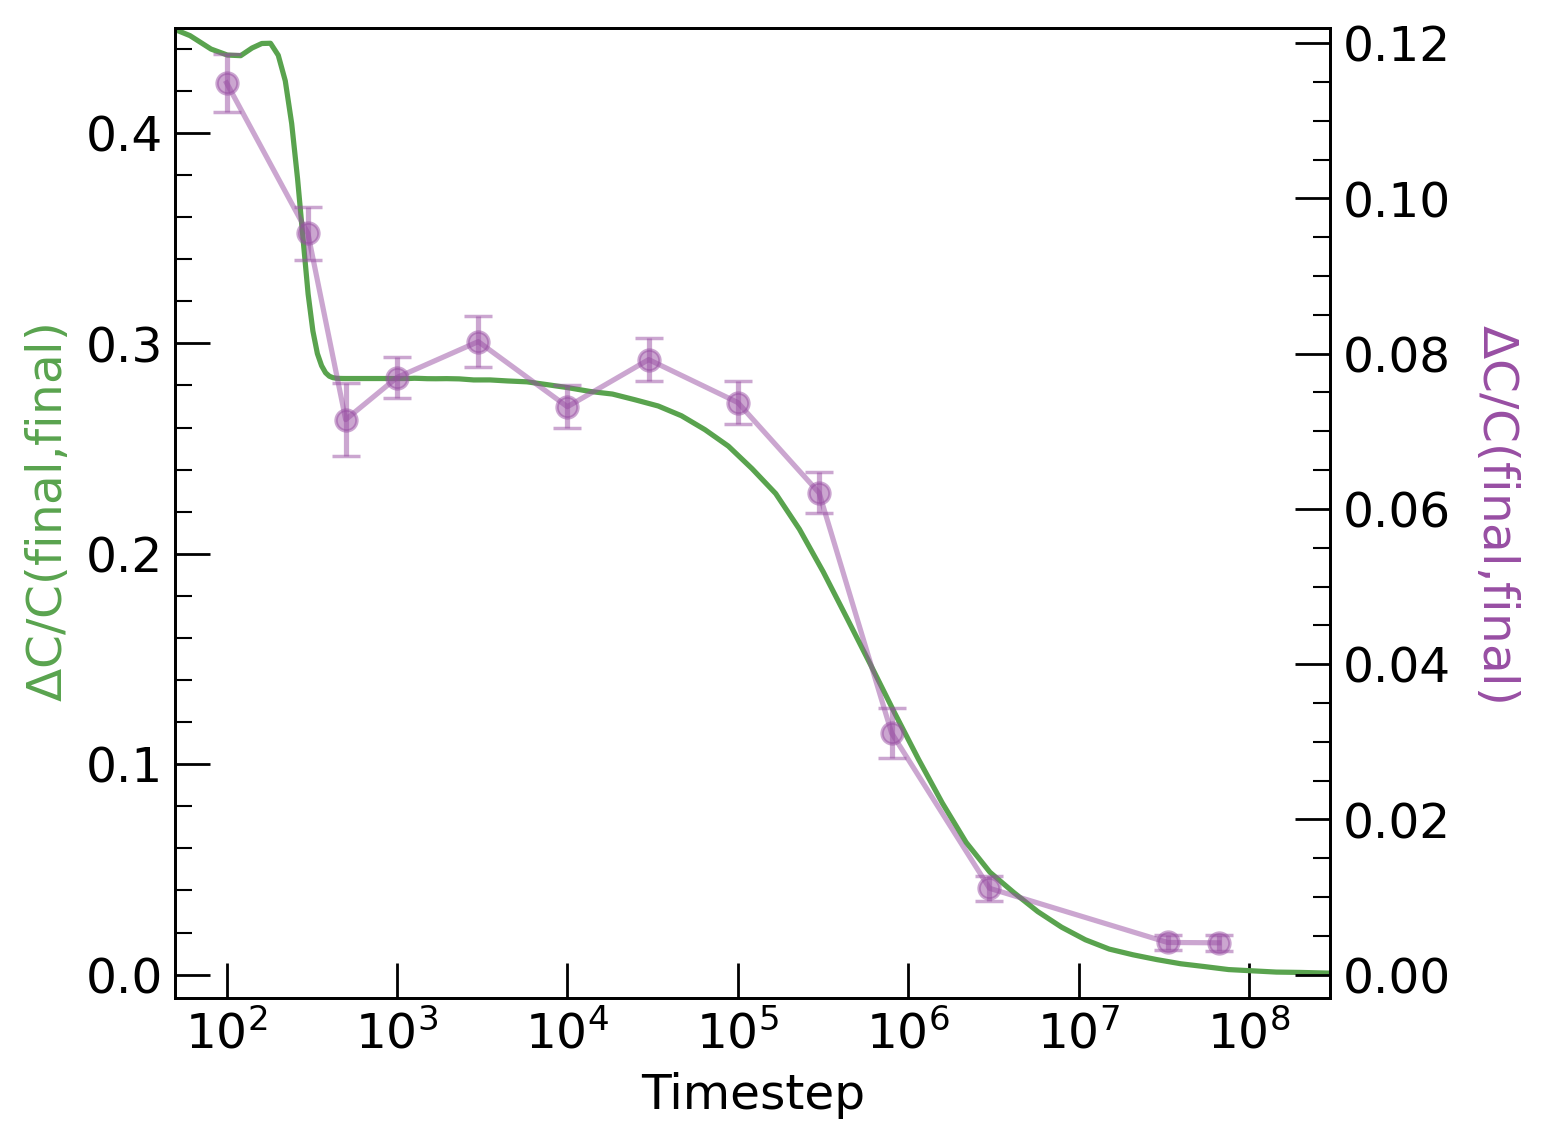

In [22]:
fig,ax_left=plt.subplots()
plt.tick_params('both',which='both',top=False)
plt.tick_params('x',which='minor',bottom=False)
ax_right=ax_left.twinx()
ax_right.errorbar(delays[sorted_inds],corr_means[sorted_inds],
                  yerr=corr_stds[sorted_inds],fmt='o-',capsize=4,
                  label='experimental',color='#984ea3',alpha=0.5,

                 )
ax_right.set_ylim(-3.05e-3,0.122)
ax_right.set_xscale('log')

# ax_right.set_ylim(2e-3,1.2e-1)
# ax_right.set_yscale('log')

# ax_right.set_xlabel('Delay (ns)')
ax_right.set_ylabel(r'$\Delta$C/C(final,final)',color='#984ea3',rotation=270,labelpad=20)
# ax_right.legend(loc=3)

ax_left.semilogx(extended_timeSteps,corr_differential,color='#59A34E',
                 linestyle='-',label='simulated')
ax_left.set_ylim(-0.01125,0.45)
ax_left.set_xlim(5e1,3e8)
ax_left.set_xticks(np.logspace(2,8,7))
# ax_left.set_xticklabels()

# ax_left.loglog(extended_timeSteps,corr_differential,color='#59A34E',linestyle='-')
# ax_left.set_xlim(5e1,3e8)
# ax_left.set_ylim(1e-3,0.66)
# ax_left.set_xticks(np.logspace(2,8,7))

ax_left.set_ylabel(r'$\Delta$C/C(final,final)',color='#59A34E')
ax_left.set_xlabel('Timestep')
# ax_left.legend()
plt.tight_layout()
# plt.savefig(os.path.join(sim_source,'Sutton-experiment-comparison_v2_ROI{}.svg'.format(ROI)))
# plt.savefig(os.path.join(sim_source,'Sutton-experiment-comparison_loglog.svg'))

load multiple comparison simulations

[['corr_funcs', 'intensity_funcs', 'ROI_mins', 'ROI_maxs', 'new_phase_area', 'timeSteps', 'percents_anneal'], ['corr_funcs', 'intensity_funcs', 'ROI_mins', 'ROI_maxs', 'new_phase_area', 'timeSteps', 'percents_anneal']]


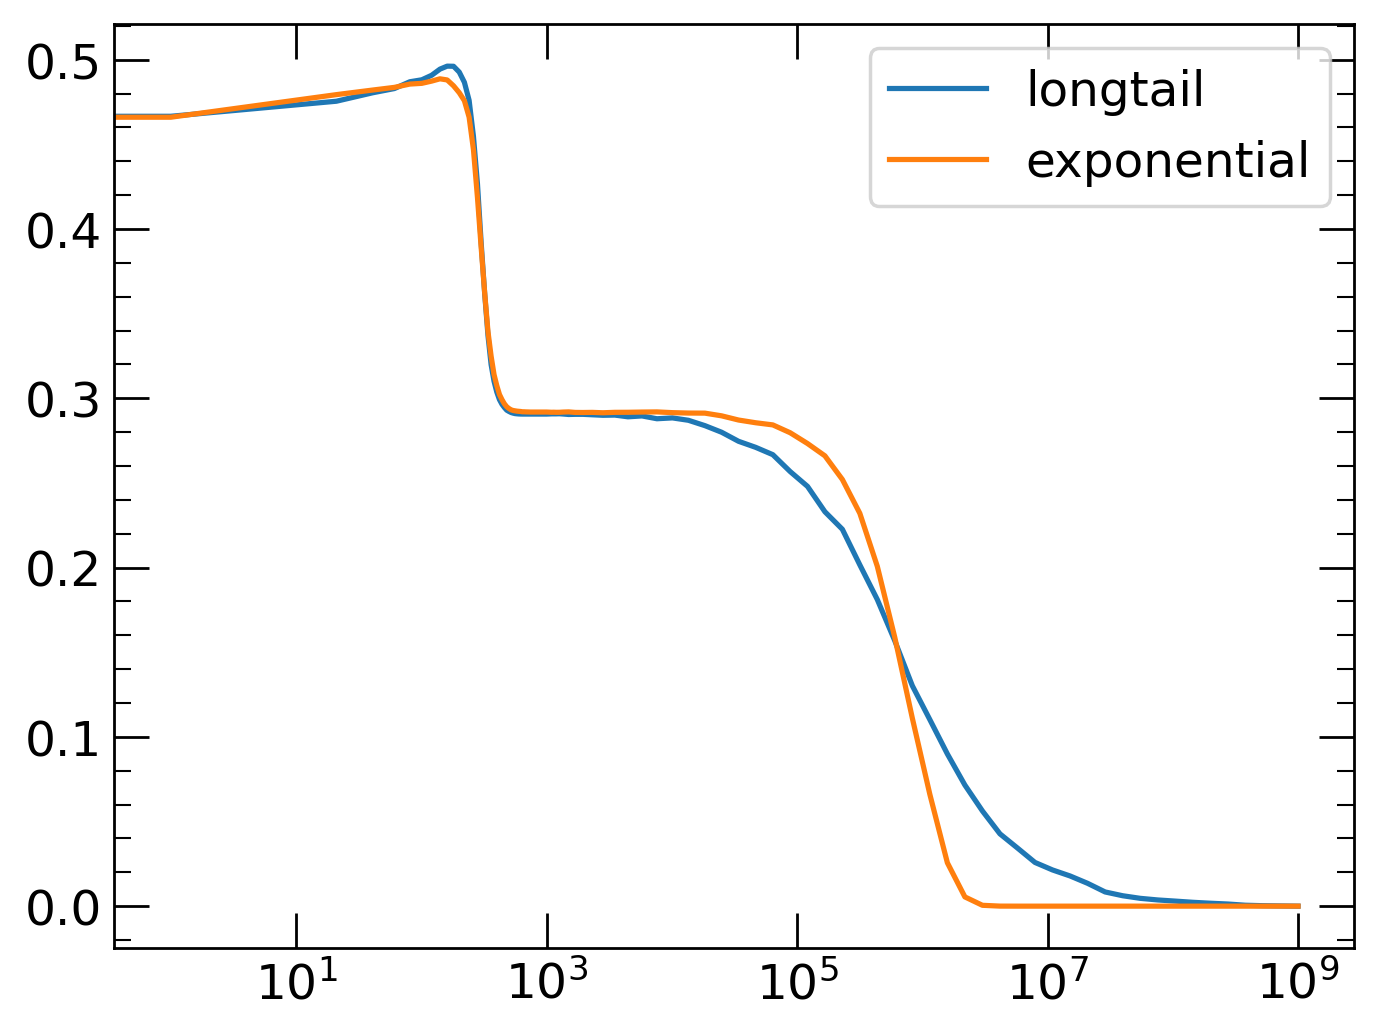

In [255]:
sim_sources=[
    # 'sim_results/longtail_liststart_average_arrays_w-area0_iter10_a96_t14e4.npz',
    'sim_results/longtail_liststart_average_arrays_w-area0_iter100_a96_t14e4.npz',
    # 'sim_results/multi_average_arrays_w-area0_longtail-paper.npz',
    # 'sim_results/multi_average_arrays_w-area0_longtail96_iter30.npz',
    # 'sim_results/multi_average_arrays_w-area0_longtail96_iter250.npz',
    # 'sim_results/longtail_multi_average_arrays_w-area5_iter10.npz',
    # 'sim_results/longtail_multi_average_arrays_w-area6_iter10.npz',
    # 'sim_results/multi_average_arrays_w-area0_exp-paper.npz',
    # 'sim_results/expon_liststart_average_arrays_w-area0_iter10_t411e3.npz'
    'sim_results/expon_liststart_average_arrays_w-area0_iter100_t411e3.npz'
            ]
labels=[
    'longtail',
        'exponential',
        # 'longtail0.96_30',
    #     'longtail0.96_250',
    # 'longtail_multistart'
       ]
data=[np.load(sim_source) for sim_source in sim_sources]
print([list(d.keys()) for d in data])
# data=np.load(os.path.join(sim_source,'multi_average_arrays_w-area0.npz'))
# data=np.load(os.path.join(sim_source,'multi_average_arrays_w-area0.npz'))
extended_timeSteps=[np.array([0,*data[k]['timeSteps']]) for k in range(len(data))]
ROI=0
raw_corrs=[data[k]['corr_funcs'][:,:,ROI] for k in range(len(data))]
avg_corr=[np.mean(raw_corrs[k],axis=0) for k in range(len(data))]
raw_ints=[data[k]['intensity_funcs'][:] for k in range(len(data))]
avg_ints=[np.mean(raw_ints[k],axis=0) for k in range(len(data))]
corr_differential=[-avg_corr[k]/avg_corr[k][-1]+1 for k in range(len(data))]
plt.figure()
for k in range(len(data)):
    plt.semilogx(extended_timeSteps[k],corr_differential[k],label=labels[k])
    # plt.semilogx(extended_timeSteps[k],corr_differential[k]/np.mean(corr_differential[k][51:61]),label=labels[k])
plt.legend()

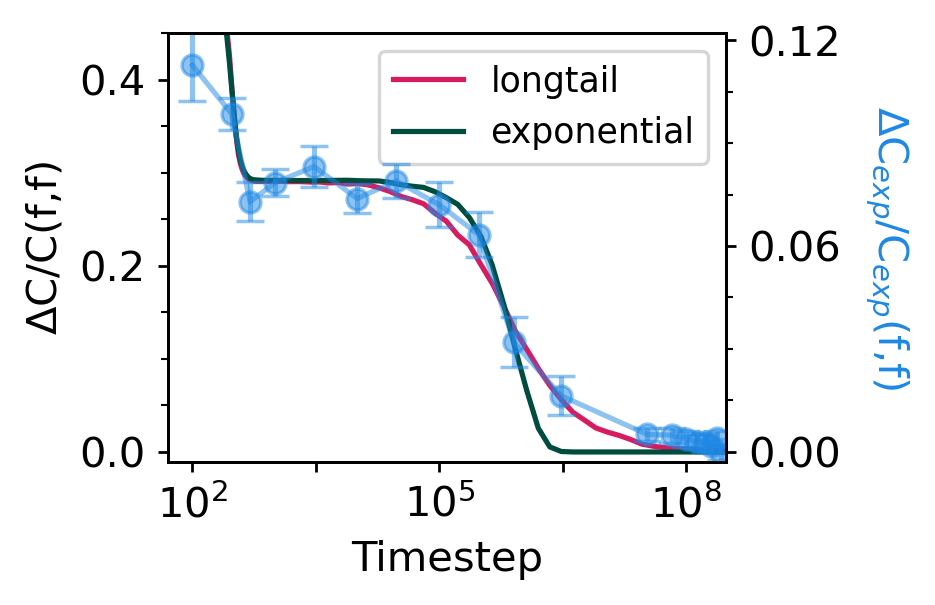

In [257]:
fig,ax_left=plt.subplots(figsize=(2.88,2.23))
ax_right=ax_left.twinx()
ax_right.errorbar(diffC_data['delays'],diffC_data['corr means'],
                  yerr=corr_stds,fmt='o-',capsize=4,
                  label='experimental',color='#1E88E5',alpha=0.5
                 )
ax_right.set_ylim(-3.05e-3,0.122)
ax_right.set_yticks([0,0.06,0.12])
ax_right.set_xscale('log')
ax_right.xaxis.tick_top()
ax_right.tick_params('x',which='both',direction='out',bottom=False,top=True,labelsize=12,length=3)
ax_right.tick_params('y',which='major',direction='out',bottom=False,top=True,labelsize=12,length=3)
ax_right.tick_params('y',which='minor',direction='out',length=2,labelsize=12)
# ax_right.set_ylim(2e-3,1.2e-1)
# ax_right.set_yscale('log')

# ax_right.set_xlabel('Delay (ns)',fontsize=12)
ax_right.set_ylabel(r'$\Delta$C$_{exp}$/C$_{exp}$(f,f)',color='#1E88E5',rotation=270,labelpad=20,fontsize=12)
# ax_right.legend(loc=3)
colors=['#D81B60','#004D40','#FFC107','#AA4499']
for k in range(len(data)):
    ax_left.semilogx(extended_timeSteps[k],corr_differential[k],
                     linestyle='-',label=labels[k],color=colors[k])
    # ax_left.semilogx(extended_timeSteps[k],corr_differential[k]/np.mean(corr_differential[k][51:61]),
    #                  linestyle='-',label=labels[k],color=colors[k])
ax_left.set_ylim(-0.01125,0.45)
ax_left.set_yticks([0,0.2,0.4])
# ax_left.set_ylim(-0.01375,0.55)
# ax_left.set_ylim(-1.6/40,1.6)
ax_left.set_xlim(5e1,3e8)
ax_left.set_xticks(np.logspace(2,8,5))
ax_left.tick_params('x',which='minor',direction='out',bottom=False,labelsize=12)
ax_left.tick_params('x',which='both',direction='out',top=False,length=3,labelsize=12)
ax_left.tick_params('y',which='major',direction='out',length=3,labelsize=12)
ax_left.tick_params('y',which='minor',direction='out',length=2,labelsize=12)
# # ax_left.set_xticklabels()

# # ax_left.loglog(extended_timeSteps,corr_differential,color='#59A34E',linestyle='-')
# # ax_left.set_xlim(5e1,3e8)
# # ax_left.set_ylim(1e-3,0.66)
# # ax_left.set_xticks(np.logspace(2,8,7))

ax_left.set_ylabel(r'$\Delta$C/C(f,f)',fontsize=12)
ax_left.set_xlabel('Timestep',fontsize=12)
ax_left.legend(fontsize=10)
# plt.tight_layout()
# plt.savefig(os.path.join('/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp/waiting-time-dist-comp','Sutton-experiment-delC-comp_v2_ROI{}.svg'.format(ROI)))
# plt.savefig(os.path.join('experimental_fit\\initial_fits','Sutton-experiment-dC-comparison_old.svg'))
plt.savefig(os.path.join('experimental_fit\\initial_fits','Sutton-experiment-dC-comparison_new.svg'))

In [98]:
print(delays[sorted_inds],corr_means[sorted_inds],corr_stds[sorted_inds])

[1.00e+02 3.00e+02 5.00e+02 1.00e+03 3.00e+03 1.00e+04 3.00e+04 1.00e+05
 3.00e+05 8.00e+05 3.00e+06 3.33e+07 6.66e+07] [1.04420391 1.0604221  1.07425348 1.07678754 1.08260729 1.08111332
 1.08473629 1.09098904 1.10770112 1.1420467  1.15818631 1.1684239
 1.16934773] [0.00940978 0.00428303 0.00566969 0.00395036 0.00591273 0.00408183
 0.00494097 0.00662405 0.00648767 0.00707983 0.00545328 0.00194439
 0.00209091]


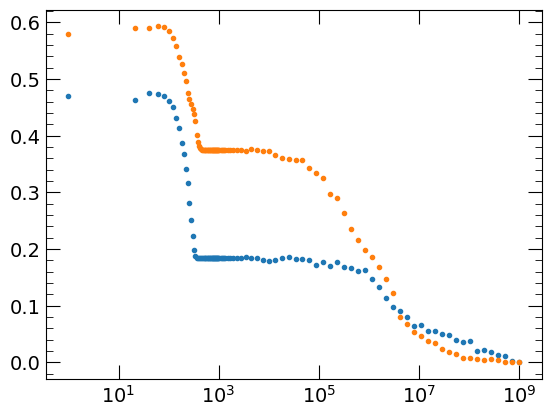

In [20]:
data_exp=np.load('cellular auto sims/log-time-early-test/include-growth/scaled-t/1000nucs_500size_51growth-scaled-time_51alpha0.50-tau1.00E+05-anneal-1.58E-02rate-markov-poisson_hard_bound5.0E-02-1.0E-02-ave10/multi_average_arrays_w-area0.npz')
data_lt=np.load('cellular auto sims/log-time-early-test/include-growth/scaled-t/1000nucs_500size_51growth-scaled-time_51alpha0.75-tau1.00E+05-anneal-1.58E-02rate-markov-poisson_hard_bound5.0E-02-1.0E-02-ave10/multi_average_arrays_w-area0.npz')

ROI=1
extended_timeSteps_exp=np.array([0,*data_exp['timeSteps']])
raw_corrs_exp=data_exp['corr_funcs'][:,:,ROI]
avg_corr_exp=np.mean(raw_corrs_exp,axis=0)
corr_differential_exp=-avg_corr_exp/avg_corr_exp[-1]+1

extended_timeSteps_lt=np.array([0,*data_lt['timeSteps']])
raw_corrs_lt=data_lt['corr_funcs'][:,:,ROI]
avg_corr_lt=np.mean(raw_corrs_lt,axis=0)
corr_differential_lt=-avg_corr_lt/avg_corr_lt[-1]+1

plt.figure()
plt.semilogx(extended_timeSteps_exp,corr_differential_exp,'.')
plt.semilogx(extended_timeSteps_lt,corr_differential_lt,'.')

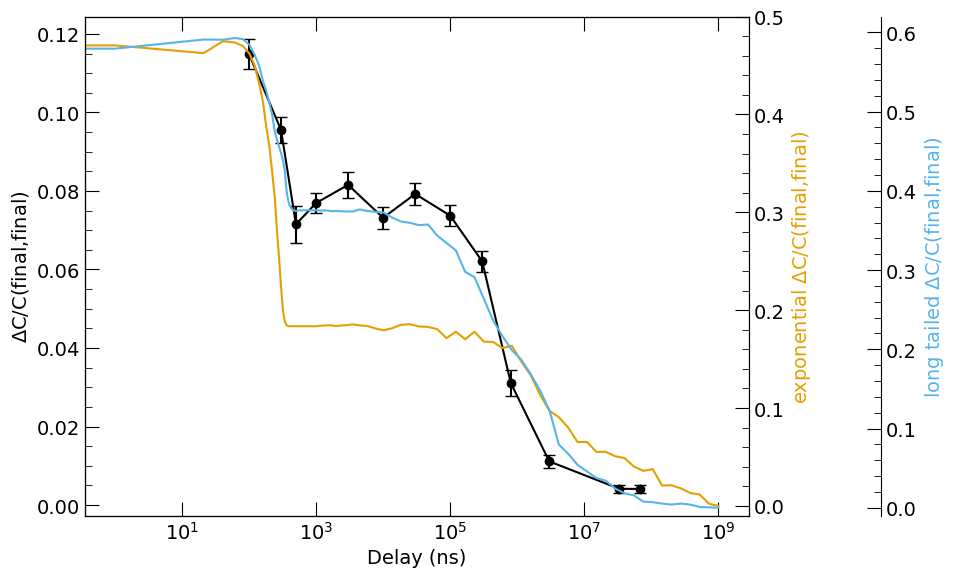

In [23]:
fig,ax_left=plt.subplots(figsize=(10,6))
ax_right=ax_left.twinx()
ax_right2=ax_left.twinx()
ax_right2.spines.right.set_position(('axes',1.2))
for ind,(qxoff,qyoff) in enumerate(on_after_norm_corrs_diff_global_avg.keys()):
    ax_left.errorbar(delays[sorted_inds],corr_means[sorted_inds],yerr=corr_stds[sorted_inds],fmt='o-',capsize=4,label=str((qxoff,qyoff)),color='k')
    ax_left.set_xscale('log')
    # ax_left.set_yscale('log')
    ax_left.set_xlabel('Delay (ns)')
    ax_left.set_ylabel(r'$\Delta$C/C(final,final)',color='k')
    ax_right.semilogx(extended_timeSteps_exp,corr_differential_exp,color='#E69F00',linestyle='-')
    ax_right.set_ylim(-0.01,0.5)
    # ax_right.loglog(extended_timeSteps_exp,corr_differential_exp,color='#E69F00',linestyle='-')
    # ax_right.set_ylim(1e-3,0.4)
    ax_right.set_ylabel(r'exponential $\Delta$C/C(final,final)',color='#E69F00')
    ax_right2.semilogx(extended_timeSteps_lt,corr_differential_lt,color='#56B4E9',linestyle='-')
    ax_right2.set_ylim(-0.01,0.62)
    # ax_right2.loglog(extended_timeSteps_lt,corr_differential_lt,color='#56B4E9',linestyle='-')
    # ax_right2.set_ylim(1e-3,0.71)
    ax_right2.set_ylabel(r'long tailed $\Delta$C/C(final,final)',color='#56B4E9')
plt.tight_layout()
# plt.savefig(os.path.join(figsaveloc,'exp-tau5e5_longtailed-tau1e5-alpha0.75_experiment_comparison.svg'))
# plt.savefig(os.path.join(figsaveloc,'exp-tau5e5_longtailed-tau1e5-alpha0.75_experiment_comparison-loglog.svg'))

In [142]:
fit_start_index=-11

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 11
    # variables        = 3
    chi-square         = 2.1028e-04
    reduced chi-square = 2.6285e-05
    Akaike info crit   = -113.514439
    Bayesian info crit = -112.320753
[[Variables]]
    amplitude:  0.07766016 +/- 0.00247116 (3.18%) (init = 0.5)
    tau:        1083905.70 +/- 179581.821 (16.57%) (init = 988000)
    stretch:    0.99464780 +/- 0.20329348 (20.44%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, stretch) = -0.473
    C(tau, stretch)       = -0.298
    C(amplitude, tau)     = -0.188


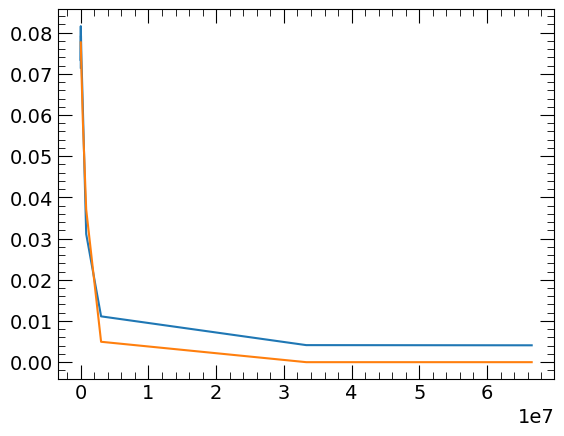

In [143]:
fitted, chisqr, A,A_err,tau, tau_err, s, s_err=fit_StretchDecayAmpChange(np.array(delays[fit_start_index:]),np.array(corr_means[fit_start_index:]),init_params=(0.5,9.88e5,1.),verbose=True,plotFit=True)

Text(0, 0.5, '$\\Delta$C/C(final,final)')

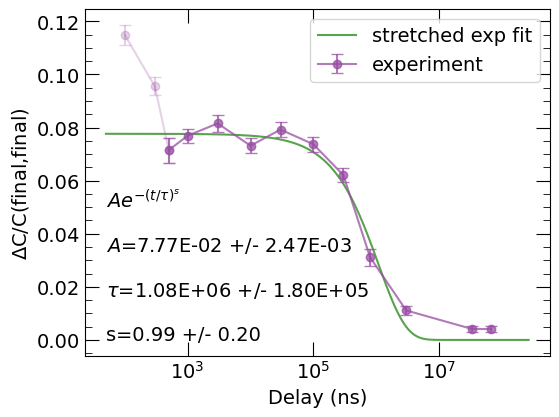

In [145]:
projected_delays=np.logspace(np.log10(np.min(delays)/2),np.log10(4*np.max(delays)),2000)
projected_fit=A*np.exp(-(projected_delays/tau)**s)
plt.figure(figsize=(6,4.5))
# projected_fit=np.exp(-(projected_delays/1e7)**0.02)
plt.semilogx(projected_delays,projected_fit,color='#59A34E',label='stretched exp fit')
# plt.semilogx(delays,fitted,'d',color='#59A34E')
plt.errorbar(delays[:fit_start_index+1],corr_means[:fit_start_index+1],yerr=corr_stds[:fit_start_index+1],fmt='o-',capsize=4,color='#984ea3',alpha=0.25)
plt.errorbar(delays[fit_start_index:],corr_means[fit_start_index:],yerr=corr_stds[fit_start_index:],fmt='o-',capsize=4,color='#984ea3',label='experiment',alpha=0.75)
# plt.ylim([0,1.05])
plt.legend()
text_ys=np.linspace(0.05,0.,4)
plt.text(50,text_ys[0],r'$A e^{-(t/\tau)^s}$')
if A_err is None:
    plt.text(50,text_ys[1],r'$A$={:.2E}'.format(A))
else:
    plt.text(50,text_ys[1],r'$A$={:.2E} +/- {:.2E}'.format(A,A_err))

if tau_err is None:
    plt.text(50,text_ys[2],r'$\tau$={:.2E}'.format(tau))
else:
    plt.text(50,text_ys[2],r'$\tau$={:.2E} +/- {:.2E}'.format(tau,tau_err))
    
if s_err is None:
    plt.text(50,text_ys[3],r's={:.2f}'.format(s))
else:
    plt.text(50,text_ys[3],r's={:.2f} +/- {:.2f}'.format(s,s_err))

plt.xlabel('Delay (ns)')
plt.ylabel(r'$\Delta$C/C(final,final)')
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_NormedSuttonStd_StretchExpFit.svg'.format(detector,ROI_size)))
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_Sutton_StretchExpFit.svg'.format(detector,ROI_size)))
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_Gorfmann_StretchExpFit.svg'.format(detector,ROI_size)))
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_SubtSuttonStd_StretchExpFit.svg'.format(detector,ROI_size)))
# plt.savefig(os.path.join(figsaveloc,'epix{}_normalized_correlation_difference_ROI{}_NormedSutton_StretchExpFit.svg'.format(detector,ROI_size)))

In [134]:
on_after_corrs_global_avg=dict.fromkeys(on_after_corrs_shot_avg.keys())
additional_rows=avg_TT.shape[0]-before_num-after_num-1
for key in on_after_corrs_shot_avg.keys():
    on_after_corrs_global_avg[key]=dict.fromkeys(on_after_corrs_shot_avg[key].keys())
for (qxoff,qyoff) in on_after_corrs_global_avg.keys():
    print('(qx offset,qy offset)=',(qxoff,qyoff))
    for delay in sorted(on_after_corrs_global_avg[(qxoff,qyoff)].keys()):
        on_after_corrs_global_avg[(qxoff,qyoff)][delay]=\
            {'mean':np.nanmean(on_after_corrs_shot_avg[(qxoff,qyoff)][delay]),
             'std err':np.nanstd(on_after_corrs_shot_avg[(qxoff,qyoff)][delay])/\
             np.sqrt(len(on_after_corrs_shot_avg[(qxoff,qyoff)][delay]))}
        for j in range(additional_rows):
            on_after_corrs_global_avg[(qxoff,qyoff)][3.33e7*(j+1)+delay]=\
                {'mean':np.nanmean(additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay][:,j]),
                 'std err':np.nanstd(additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay][:,j])/\
                 np.sqrt(len(additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay][:,j]))}
        on_after_corrs_global_avg[(qxoff,qyoff)][delay+25*3.33e7]=\
            {'mean':np.nanmean(final_after_after_corrs_shot_avg[(qxoff,qyoff)][delay]),
             'std err':np.nanstd(final_after_after_corrs_shot_avg[(qxoff,qyoff)][delay])/\
             np.sqrt(len(final_after_after_corrs_shot_avg[(qxoff,qyoff)][delay]))}
        # on_after_corrs_global_avg[(qxoff,qyoff)][6.66e7+delay]=\
        #     {'mean':np.nanmean(additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay][:,1]),
        #      'std err':np.nanstd(additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay][:,1])/\
        #      np.sqrt(len(additional_on_after_corrs_shot_avg[(qxoff,qyoff)][delay][:,1]))}
        print(len(on_after_corrs_shot_avg[(qxoff,qyoff)][delay]),
              on_after_corrs_global_avg[(qxoff,qyoff)][delay])

(qx offset,qy offset)= (0, 0)
40 {'mean': 1.0466129551877326, 'std err': 0.010430335692779468}
20 {'mean': 1.0600698663558177, 'std err': 0.0047212843114911645}
13 {'mean': 1.0755432363099289, 'std err': 0.005695552889153239}
20 {'mean': 1.0759107295403318, 'std err': 0.003959769660717296}
20 {'mean': 1.0833236310616536, 'std err': 0.006009095494526197}
20 {'mean': 1.0807031693482667, 'std err': 0.004186936755147178}
20 {'mean': 1.0852569878196596, 'std err': 0.005020631752849242}
20 {'mean': 1.0917949486590057, 'std err': 0.006566118558085966}
20 {'mean': 1.1082021589891302, 'std err': 0.006483311176306048}
20 {'mean': 1.141946782311306, 'std err': 0.007252002856965409}
40 {'mean': 1.1575103353148992, 'std err': 0.005699794026406965}


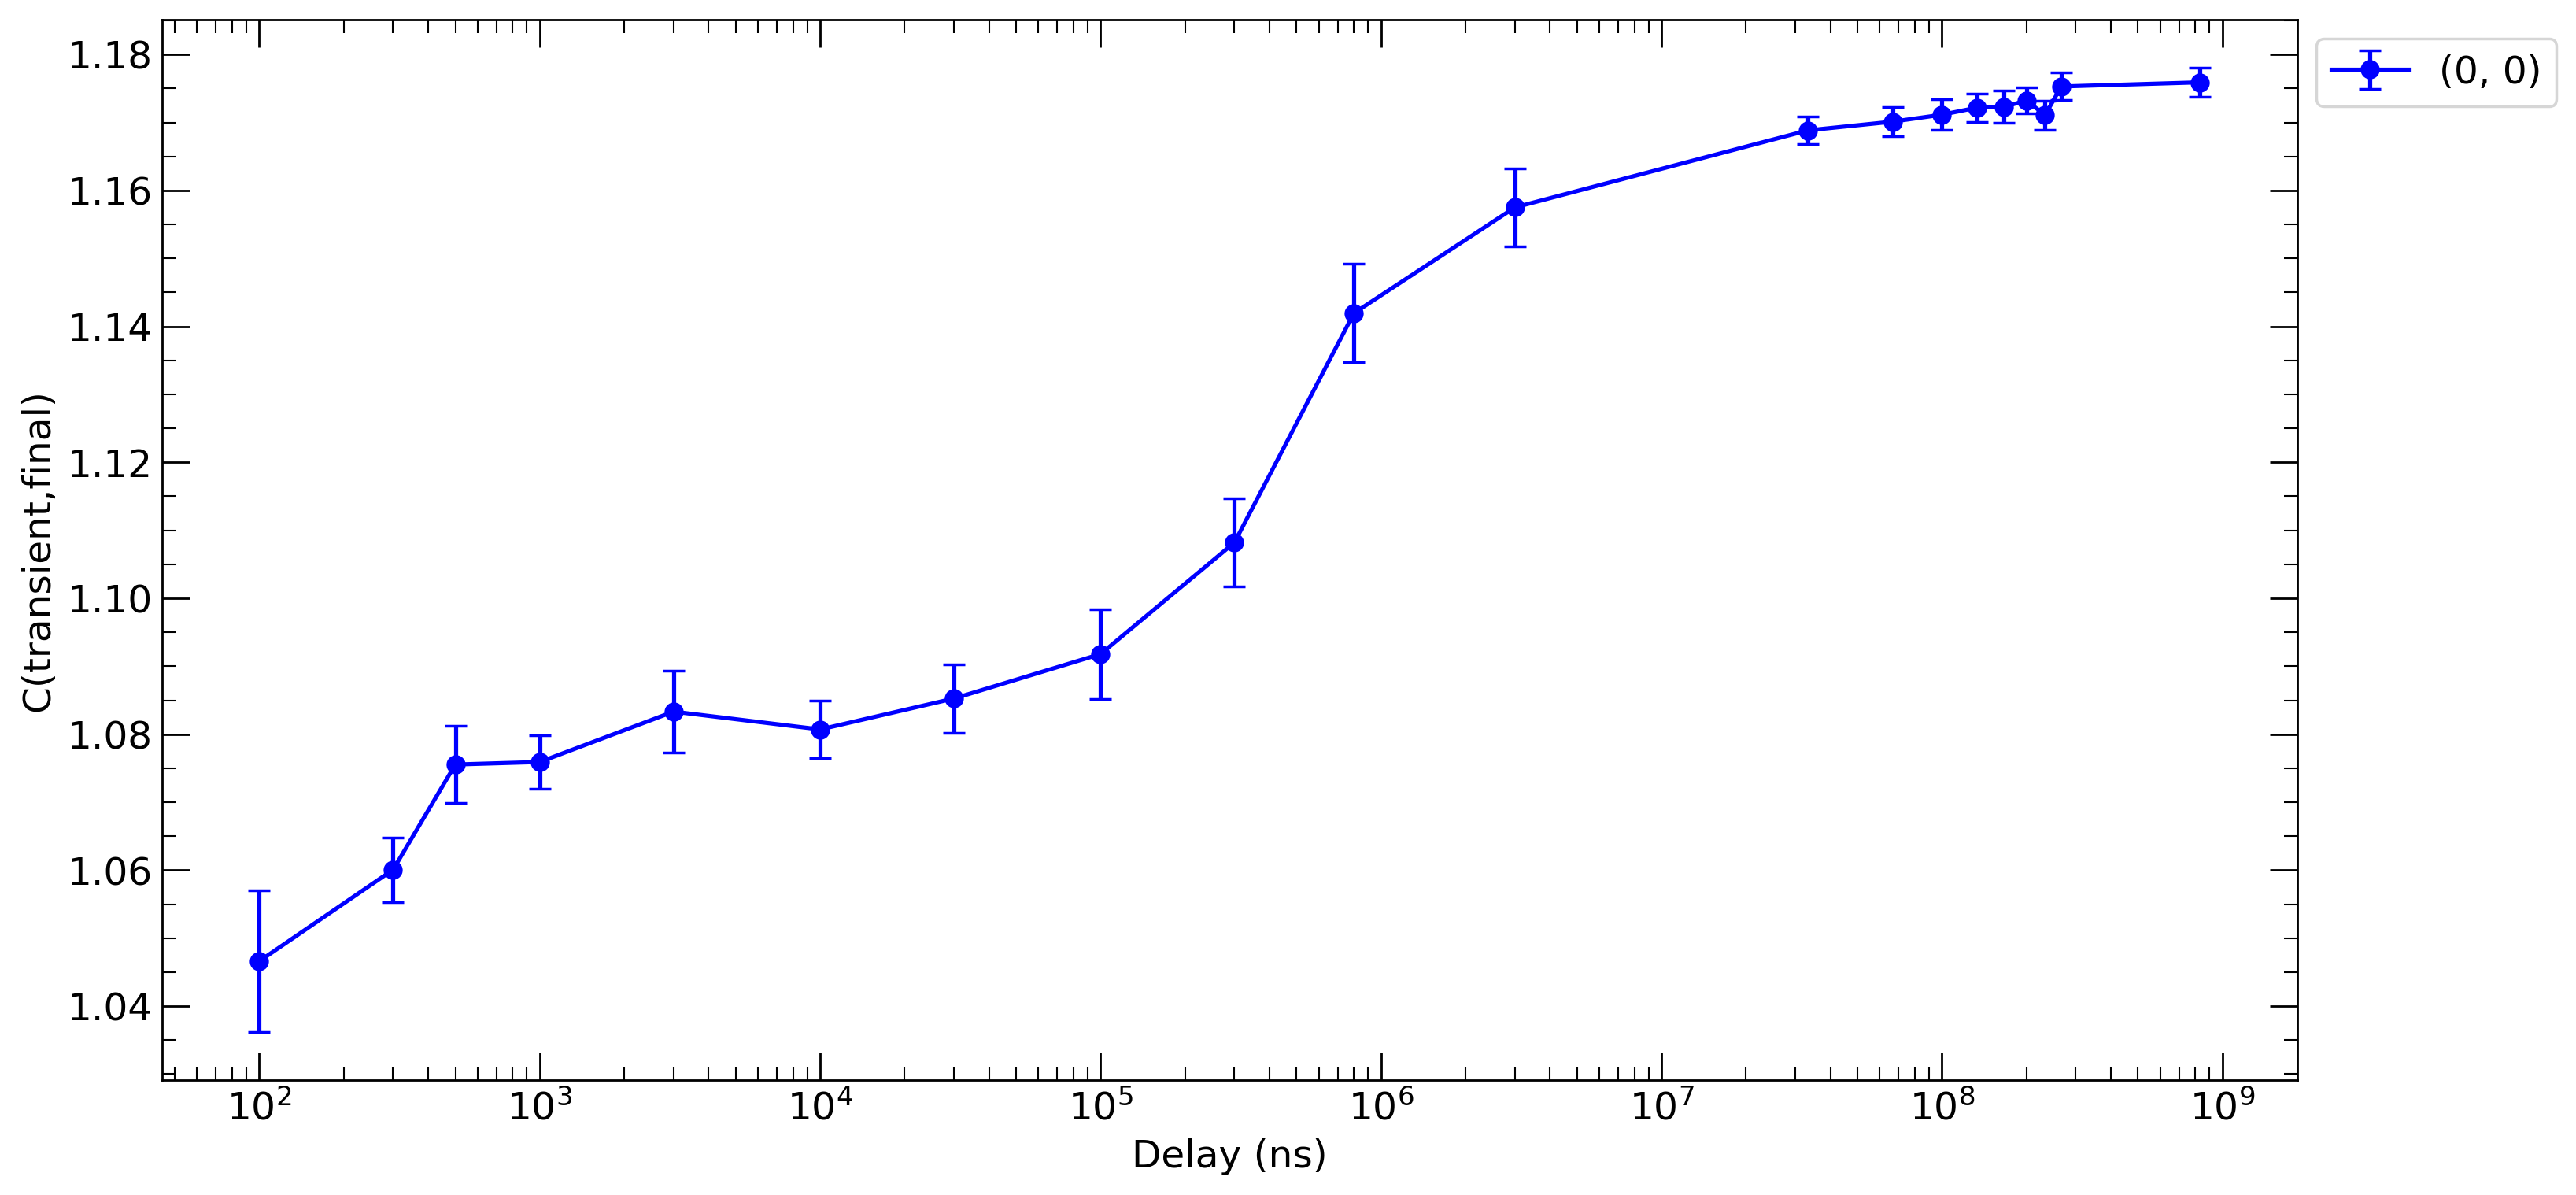

In [136]:
plt.figure(figsize=(14,7))
colors=pylab.cm.brg(np.linspace(0,1,len(on_after_corrs_global_avg.keys())))
for ind,(qxoff,qyoff) in enumerate(on_after_corrs_global_avg.keys()):
    delays_raw,corr_means_raw,corr_stds_raw=plottable_lists_from_meanstd_dict(on_after_corrs_global_avg[(qxoff,qyoff)])
    delays_raw=np.array(delays_raw)
    corr_means_raw=np.array(corr_means_raw)
    corr_stds_raw=np.array(corr_stds_raw)
    beginning_inds=delays_raw<3.33e7
    end_inds=delays_raw>8e8
    delays=np.concatenate((delays_raw[beginning_inds],np.array(additional_delays),np.array([25*3.33e7])))
    corr_means_additional=[]
    corr_stds_additional=[]
    for add_delay in additional_delays:
        inds_add=np.logical_and(delays_raw>add_delay,delays_raw<add_delay+3.33e7)
        corr_means_additional.append(np.mean(corr_means_raw[inds_add]))
        corr_stds_additional.append(np.sqrt(np.sum(np.array(corr_stds_raw[inds_add])**2))/np.sum(inds_add))
    corr_means=np.concatenate((corr_means_raw[beginning_inds],np.array(corr_means_additional),np.array([np.mean(corr_means_raw[end_inds])])))
    corr_stds=np.concatenate((corr_stds_raw[beginning_inds],np.array(corr_stds_additional),np.array([np.sqrt(np.sum(np.array(corr_stds_raw[end_inds])**2))/np.sum(end_inds)])))
    plt.errorbar(delays,corr_means,yerr=corr_stds,fmt='o-',capsize=4,label=str((qxoff,qyoff)),color=colors[ind])
#     plt.plot(delays,corr_means,'o-',label=str((qxoff,qyoff)),color=colors[ind])
    plt.xscale('log')
#     plt.yscale('log')
    plt.xlabel('Delay (ns)')
    plt.ylabel('C(transient,final)')
    # plt.xlim([0,0.35e7])
#     plt.ylim([0.5,1.5])
plt.legend(bbox_to_anchor=(1,1))
# plt.savefig(os.path.join(figsaveloc,'epix{}_correlation_delay_curve.png'.format(detector)))
# plt.savefig(os.path.join(figsaveloc,'epix{}_correlation_delay_curve_ROI{}_Sutton.svg'.format(detector,ROI_size)))
# plt.savefig(os.path.join(figsaveloc,'epix{}_correlation_delay_curve_ROI{}_NormedSuttonStd.svg'.format(detector,ROI_size)))

run the following cell to save C separately

In [139]:
C_data={'delays':delays,'corr means':corr_means,'corr err':corr_stds}
print(C_data)

{'delays': array([1.000e+02, 3.000e+02, 5.000e+02, 1.000e+03, 3.000e+03, 1.000e+04,
       3.000e+04, 1.000e+05, 3.000e+05, 8.000e+05, 3.000e+06, 3.330e+07,
       6.660e+07, 9.990e+07, 1.332e+08, 1.665e+08, 1.998e+08, 2.331e+08,
       2.664e+08, 8.325e+08]), 'corr means': array([1.04661296, 1.06006987, 1.07554324, 1.07591073, 1.08332363,
       1.08070317, 1.08525699, 1.09179495, 1.10820216, 1.14194678,
       1.15751034, 1.16884723, 1.17011988, 1.17114181, 1.17217898,
       1.17229503, 1.1732415 , 1.17110235, 1.17529494, 1.17590713]), 'corr err': array([0.01043034, 0.00472128, 0.00569555, 0.00395977, 0.0060091 ,
       0.00418694, 0.00502063, 0.00656612, 0.00648331, 0.007252  ,
       0.00569979, 0.00197846, 0.00213111, 0.00227109, 0.00209691,
       0.00238946, 0.00191025, 0.002141  , 0.0020341 , 0.00215067])}


In [264]:
corr_savepath='./'
with open(os.path.join(corr_savepath,'ROI{}_Sutton_C_833ms.pickle'.format(ROI_size)), 'wb') as handle:
    pickle.dump(C_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(corr_savepath,'ROI{}_Sutton_dC_833ms.pickle'.format(ROI_size)), 'wb') as handle:
    pickle.dump(diffC_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# np.savez(os.path.join(corr_savepath,'ROI{}_corr_Sutton.npz'.format(ROI_size)),allowC_data=C_data,diffC_data=diffC_data)

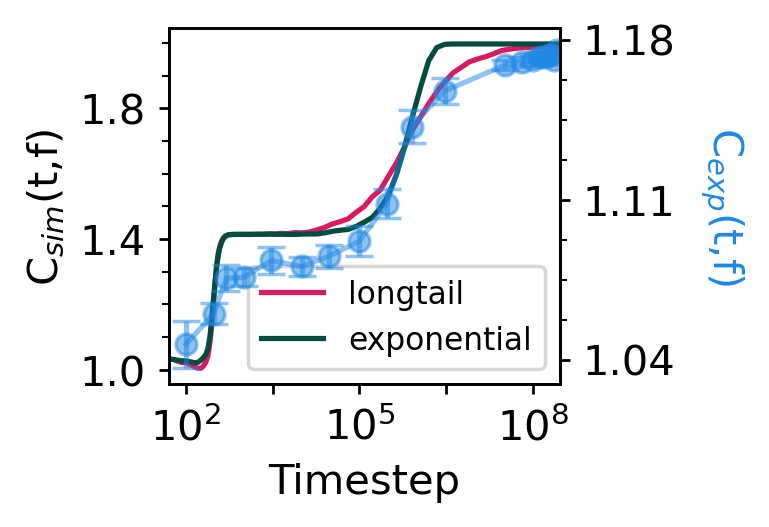

In [259]:
fig,ax_left=plt.subplots(figsize=(3.3,2.32))
ax_right=ax_left.twinx()
ax_right.errorbar(C_data['delays'],C_data['corr means'],
                  yerr=C_data['corr err'],fmt='o-',capsize=4,
                  label='experimental',color='#1E88E5',alpha=0.5
                 )
# ax_right.set_ylim(0.985,1.18)

# ax_right.set_xscale('log')
ax_right.xaxis.tick_top()
# ax_right.set_ylim(1,1.185)
ax_right.set_yticks([1.04,1.11,1.18])
ax_right.tick_params('x',which='both',direction='out',bottom=False,top=True,labelsize=12,length=3)
ax_right.tick_params('y',which='major',direction='out',bottom=False,top=True,labelsize=12,length=3)
ax_right.tick_params('y',which='minor',direction='out',length=2,labelsize=12)
# ax_right.set_ylim(2e-3,1.2e-1)
# ax_right.set_yscale('log')

ax_right.set_xlabel('Delay (ns)')
ax_right.set_ylabel(r'C$_{exp}$(t,f)',color='#1E88E5',rotation=270,labelpad=20,fontsize=12)
# ax_right.legend(loc=3)
colors=['#D81B60','#004D40','#FFC107','#AA4499']
for k in range(len(data)):
    ax_left.semilogx(extended_timeSteps[k],avg_corr[k],
                     linestyle='-',label=labels[k],color=colors[k])
# ax_left.set_ylim(-0.015,0.6)avg
ax_left.set_xlim(5e1,3e8)
ax_left.set_xticks(np.logspace(2,8,5))
ax_left.set_yticks([1,1.4,1.8])
ax_left.tick_params('x',which='minor',direction='out',bottom=False,labelsize=12)
ax_left.tick_params('x',which='both',direction='out',top=False,length=3,labelsize=12)
ax_left.tick_params('y',which='major',direction='out',length=3,labelsize=12)
ax_left.tick_params('y',which='minor',direction='out',length=2,labelsize=12)
# ax_left.set_xscale('linear')
# # ax_left.set_xticklabels()

# # ax_left.loglog(extended_timeSteps,corr_differential,color='#59A34E',linestyle='-')
# ax_left.set_xlim(5e1,5e6)
# # ax_left.set_ylim(1e-3,0.66)
# # ax_left.set_xticks(np.logspace(2,8,7))

ax_left.set_ylabel(r'C$_{sim}$(t,f)',fontsize=12)
ax_left.set_xlabel('Timestep',fontsize=12)
ax_left.legend(fontsize=9)
plt.tight_layout()
# plt.savefig(os.path.join('/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp/waiting-time-dist-comp','Sutton-experiment-C-comp_v2_ROI{}.svg'.format(ROI)))
# plt.savefig(os.path.join('experimental_fit\\initial_fits','Sutton-experiment-C-comparison_old.svg'))
plt.savefig(os.path.join('experimental_fit\\initial_fits','Sutton-experiment-C-comparison_new.svg'))

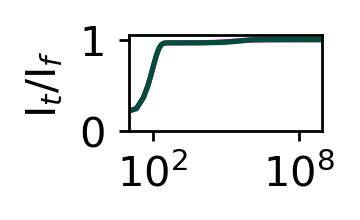

In [261]:
fig,ax=plt.subplots(figsize=(1,0.5))
colors=['#D81B60','#004D40','#FFC107','#AA4499']
for k,d in enumerate(data):
    plt.semilogx(extended_timeSteps[k],np.mean(d['intensity_funcs'],axis=0),color=colors[k])

ax.set_yticks([0,1])
ax.set_ylim(0,1.05)
ax.set_xlim(1e1,9e8)
ax.set_xticks([1e2,1e8])
ax.tick_params('x',which='both',length=3,labelsize=12,top=False,direction='out')
ax.tick_params('y',which='major',length=3,labelsize=12,right=False,direction='out')
ax.tick_params('y',which='minor',right=False,left=False,direction='out')
ax.set_ylabel(r'I$_{t}$/I$_{f}$',fontsize=12)
plt.savefig(os.path.join('experimental_fit\\initial_fits','intensity-ratio_new.svg'))

In [211]:
avg_i_ratios={}
for delay in combined_data_is.keys():
    avg_i_ratios[delay]={'mean':np.nanmean(combined_data_is[delay]),'std err':np.sqrt(len(combined_data_is[delay]))**-1*np.nanstd(combined_data_is[delay])}
# print(avg_i_ratios)

In [213]:
avg_diffI_ratios={}
for delay in avg_i_ratios.keys():
    avg_diffI_ratios[delay]={'mean':1-avg_i_ratios[delay]['mean'],'std err':avg_i_ratios[delay]['std err']}
    # print(avg_diffI_ratios[delay]['mean'])

In [215]:
avg_i_ratios

{3000000: {'mean': 0.9018898738552386, 'std err': 0.009005170223751097},
 33300000.0: {'mean': 0.9432114518060313, 'std err': 0.0028828271373123977},
 66600000.0: {'mean': 0.9581264516266498, 'std err': 0.0028547097715149834},
 99900000.0: {'mean': 0.9650052275039734, 'std err': 0.002692193577788435},
 133200000.0: {'mean': 0.9745079796125343, 'std err': 0.0028886846689495636},
 166500000.0: {'mean': 0.9770506797301832, 'std err': 0.002599205191411938},
 199800000.0: {'mean': 0.978361510535834, 'std err': 0.0024796208727928654},
 233100000.0: {'mean': 0.9829823752685288, 'std err': 0.0022894730272350803},
 266400000.0: {'mean': 0.98369806337976, 'std err': 0.0024324153256553645},
 832500000.0: {'mean': 1.0107358736454886, 'std err': 0.002281434938095053},
 100: {'mean': 0.10152410497669856, 'std err': 0.01227319952904796},
 1000: {'mean': 0.6219736346769619, 'std err': 0.01869280345429646},
 10000: {'mean': 0.8087122152619184, 'std err': 0.009758681427531942},
 100000: {'mean': 0.88613

Text(0, 0.5, '$I_{transient}$/$I_{final}$')

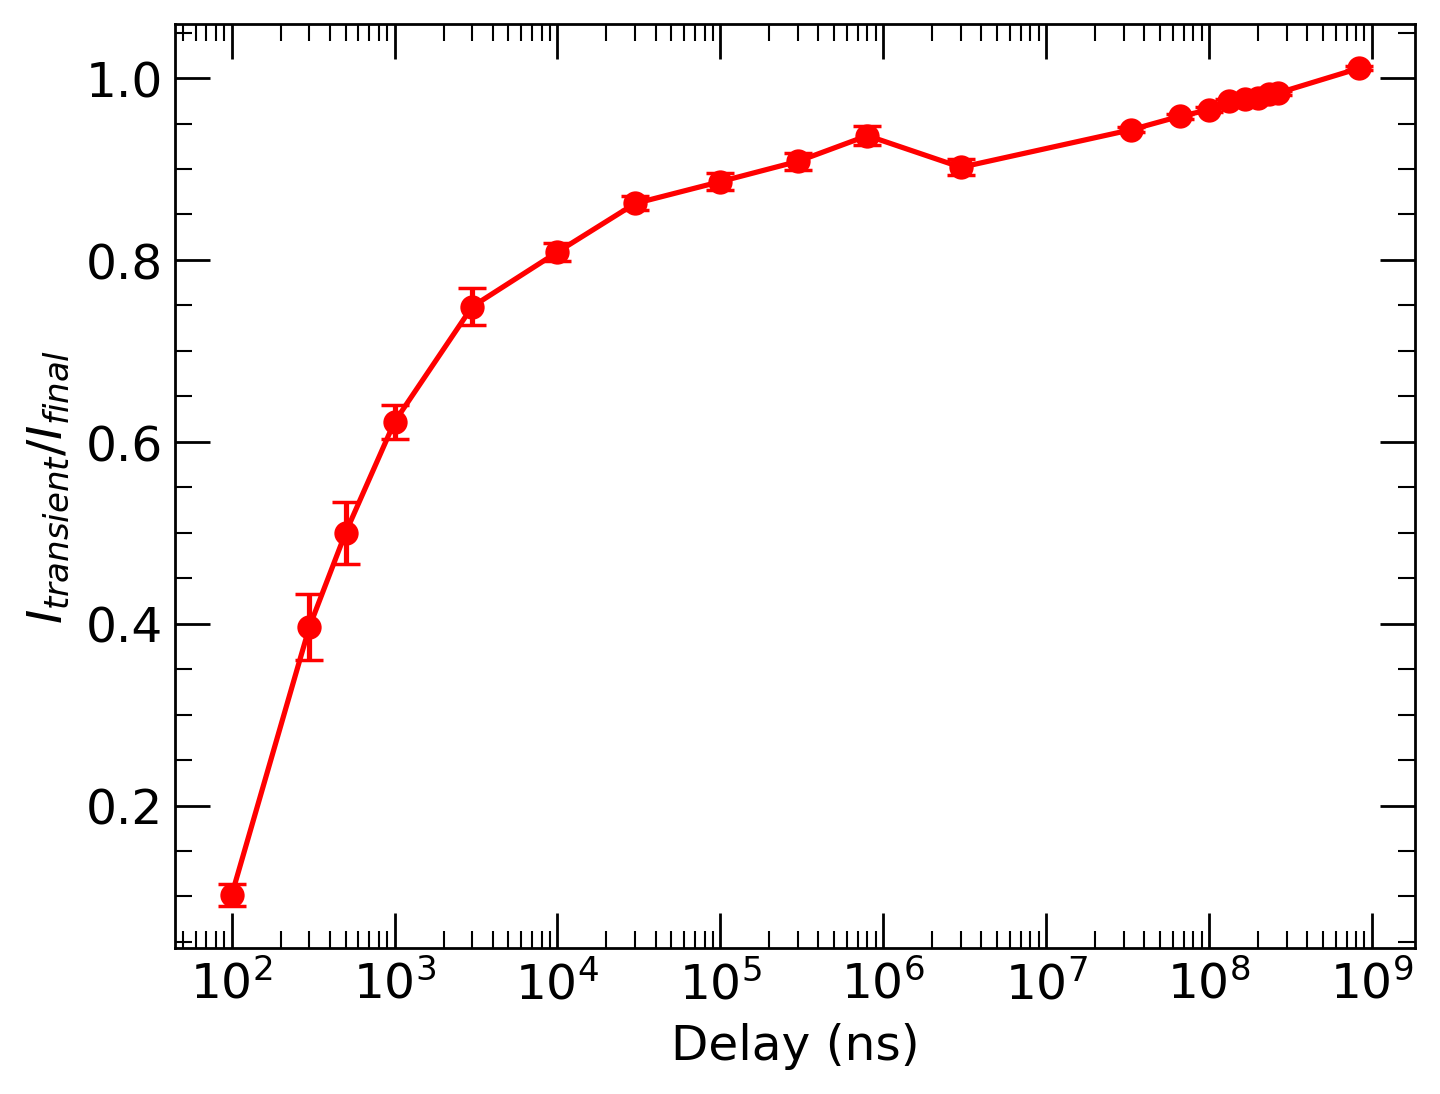

In [347]:
plt.figure()
delays_i,i0_means,i0_stds=plottable_lists_from_meanstd_dict(avg_i_ratios)
plt.errorbar(delays_i,i0_means,yerr=i0_stds,fmt='ro-',capsize=4)
plt.xscale('log')
plt.xlabel('Delay (ns)')
plt.ylabel('$I_{transient}$/$I_{final}$')
# plt.ylim([0,1])
# plt.savefig(os.path.join(figsaveloc,'epix{}_intensity_ratio_delay_curve.png'.format(detector)))

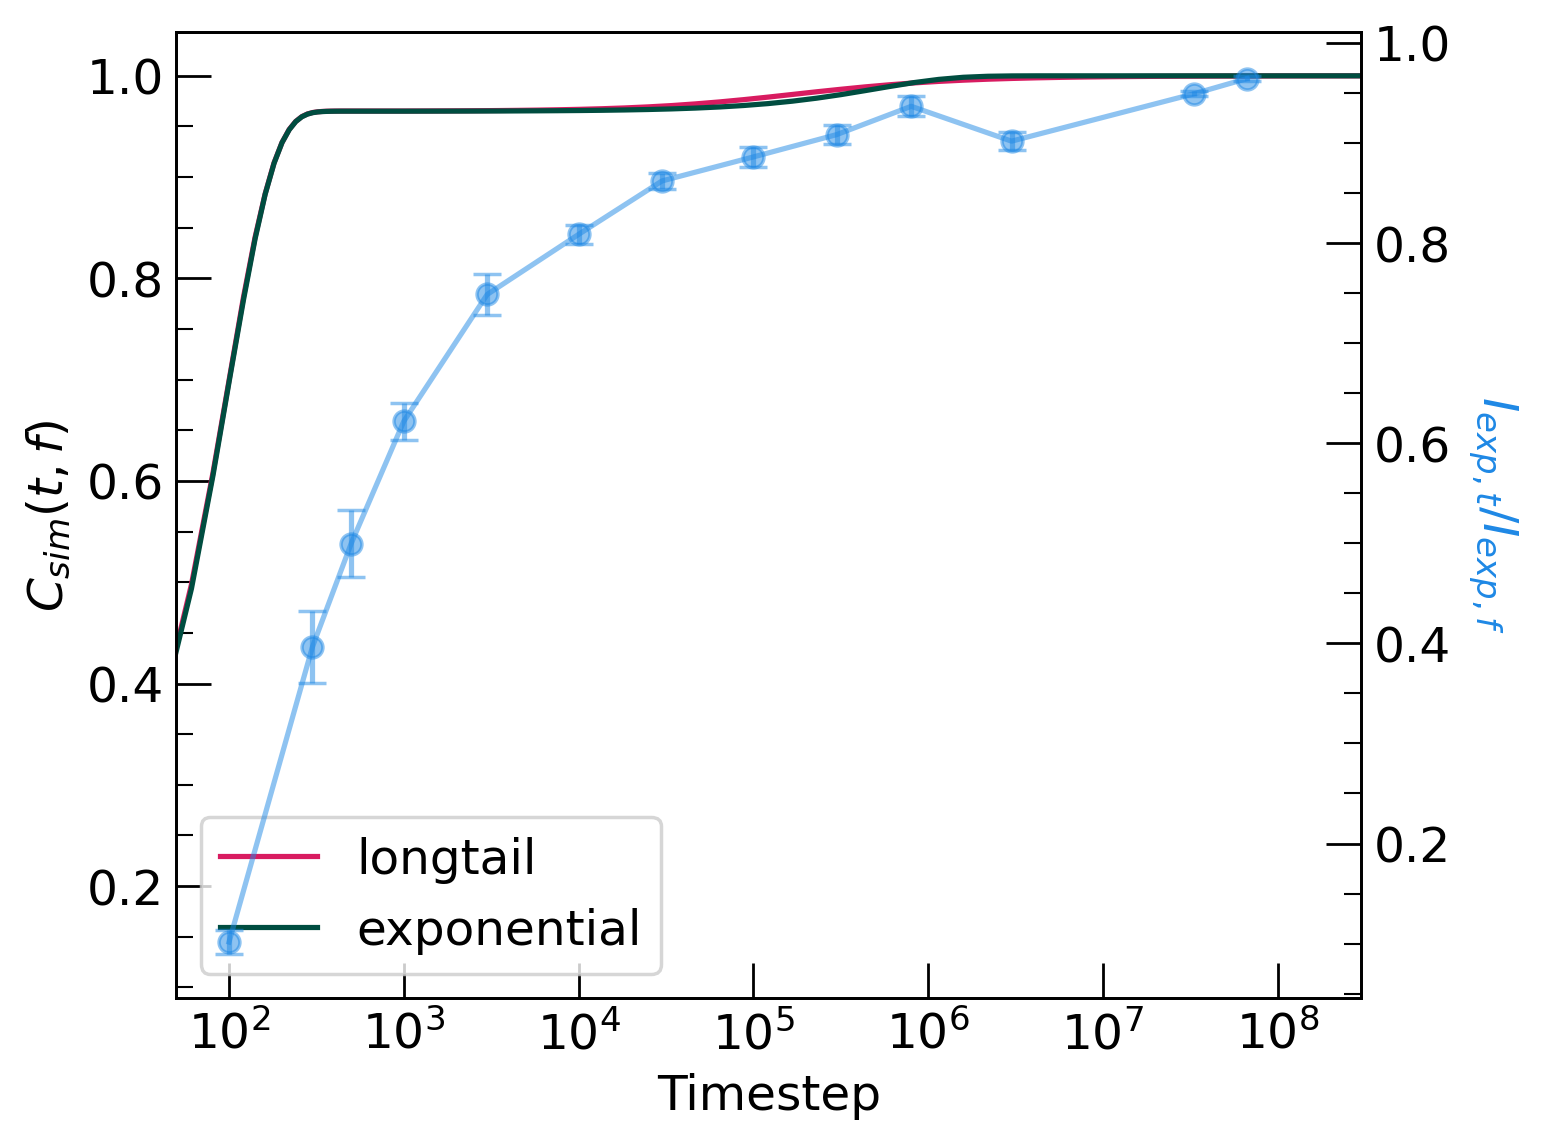

In [95]:
fig,ax_left=plt.subplots()
ax_right=ax_left.twinx()
ax_right.errorbar(delays_i,i0_means,yerr=i0_stds,marker='o',capsize=4,
                  label='experimental',color='#1E88E5',alpha=0.5
                 )
# ax_right.set_ylim(-3.05e-3,0.122)
# ax_right.set_xscale('log')
ax_right.xaxis.tick_top()
ax_right.tick_params('x',which='both',bottom=False,top=True)
# ax_right.set_ylim(2e-3,1.2e-1)
# ax_right.set_yscale('log')

ax_right.set_xlabel('Delay (ns)')
ax_right.set_ylabel(r'$I_{exp,t}/I_{exp,f}$',color='#1E88E5',rotation=270,labelpad=20)
# ax_right.legend(loc=3)
colors=['#D81B60','#004D40']
labels=['longtail','exponential']
for k in range(len(data)):
    ax_left.semilogx(extended_timeSteps[k],avg_ints[k],
                     linestyle='-',label=labels[k],color=colors[k])
# ax_left.set_ylim(-0.015,0.6)avg
ax_left.set_xlim(5e1,3e8)
ax_left.set_xticks(np.logspace(2,8,7))
ax_left.tick_params('x',which='minor',bottom=False)
ax_left.tick_params('x',which='both',top=False)
# ax_left.set_xscale('linear')
# # ax_left.set_xticklabels()

# # ax_left.loglog(extended_timeSteps,corr_differential,color='#59A34E',linestyle='-')
# ax_left.set_xlim(5e1,5e6)
# # ax_left.set_ylim(1e-3,0.66)
# # ax_left.set_xticks(np.logspace(2,8,7))

ax_left.set_ylabel(r'$C_{sim}(t,f)$')
ax_left.set_xlabel('Timestep')
ax_left.legend()
plt.tight_layout()
# plt.savefig(os.path.join('/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp/waiting-time-dist-comp','Sutton-experiment-C-comp_v2_ROI{}.svg'.format(ROI)))
# plt.savefig(os.path.join(sim_source,'Sutton-experiment-comparison_loglog.svg'))

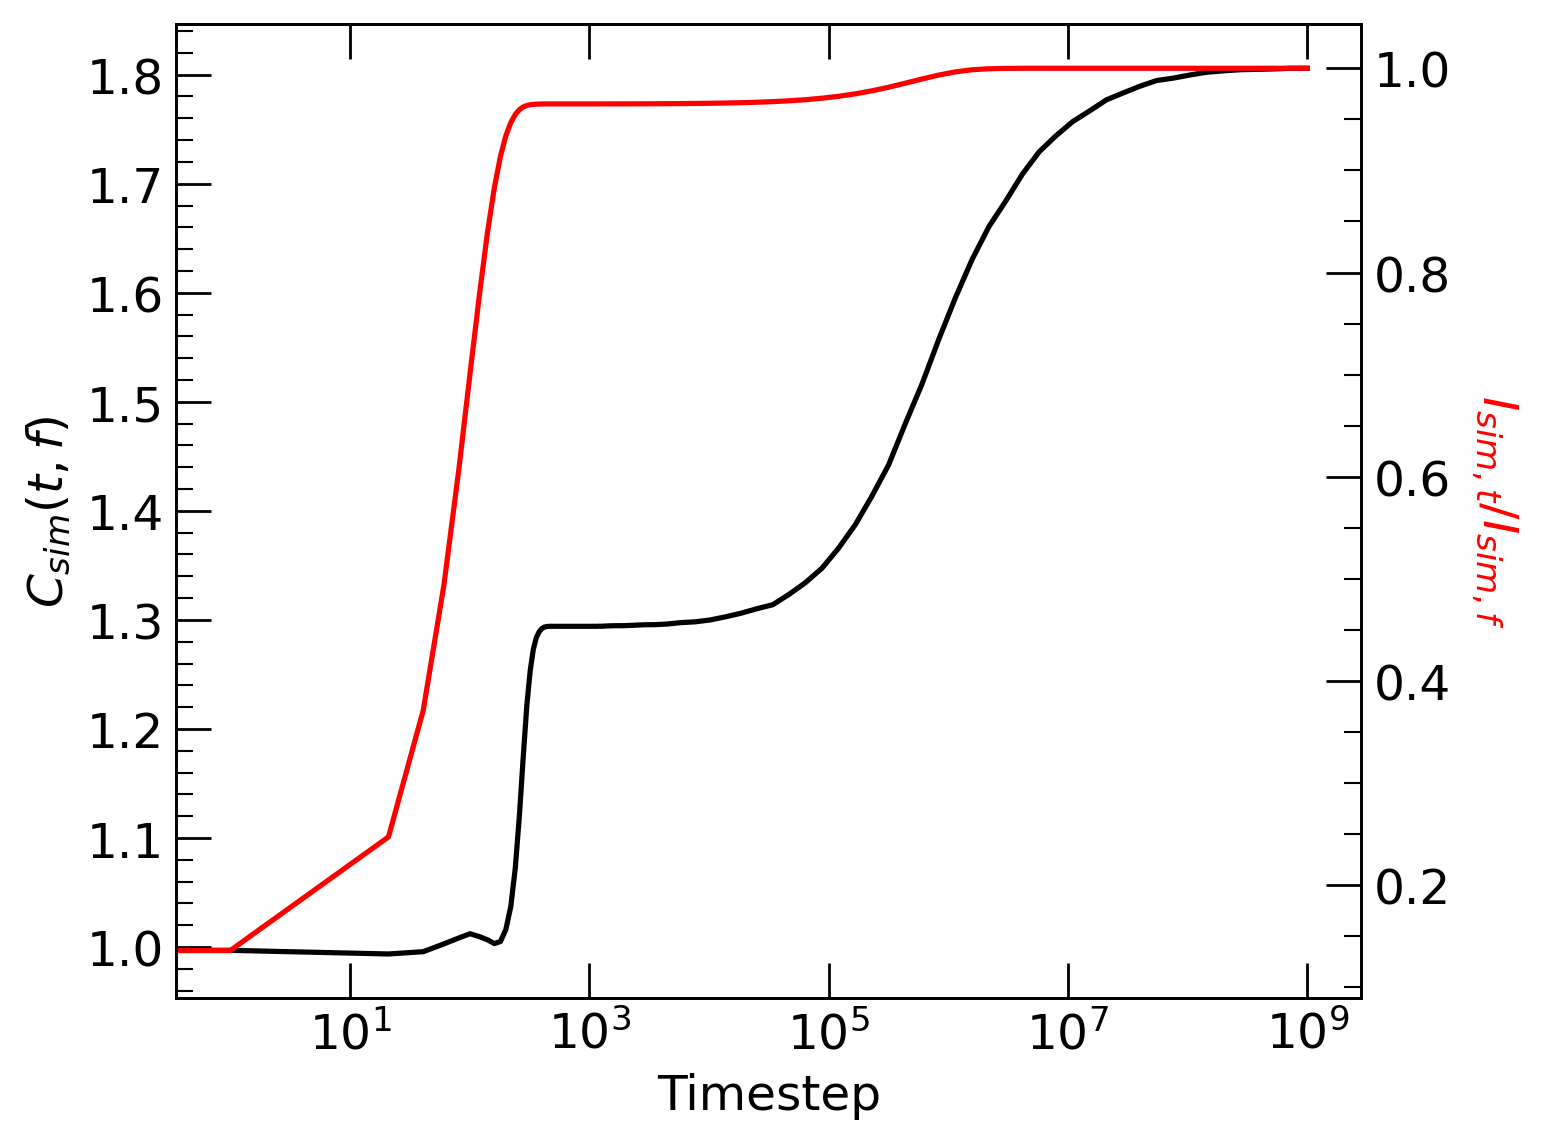

In [108]:
data_ind=0
fig,ax_left=plt.subplots()
ax_right=ax_left.twinx()
ax_left.semilogx(extended_timeSteps[data_ind],avg_corr[data_ind],color='black')
ax_right.semilogx(extended_timeSteps[k],avg_ints[k],color='red')

ax_right.set_ylabel(r'$I_{sim,t}/I_{sim,f}$',color='red',rotation=270,labelpad=20)
ax_left.set_ylabel(r'$C_{sim}(t,f)$')
ax_left.set_xlabel('Timestep')
plt.tight_layout()
# plt.savefig(os.path.join('/cds/home/m/mangu2/Documents/Phase Change XCS Model/cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp/waiting-time-dist-comp','Sutton-experiment-C-comp_v2_ROI{}.svg'.format(ROI)))
# plt.savefig(os.path.join(sim_source,'Sutton-experiment-comparison_loglog.svg'))

In [87]:
avg_ints[k].shape

(250, 103)

Text(0, 0.5, '$\\Delta$I/$I_{final}$')

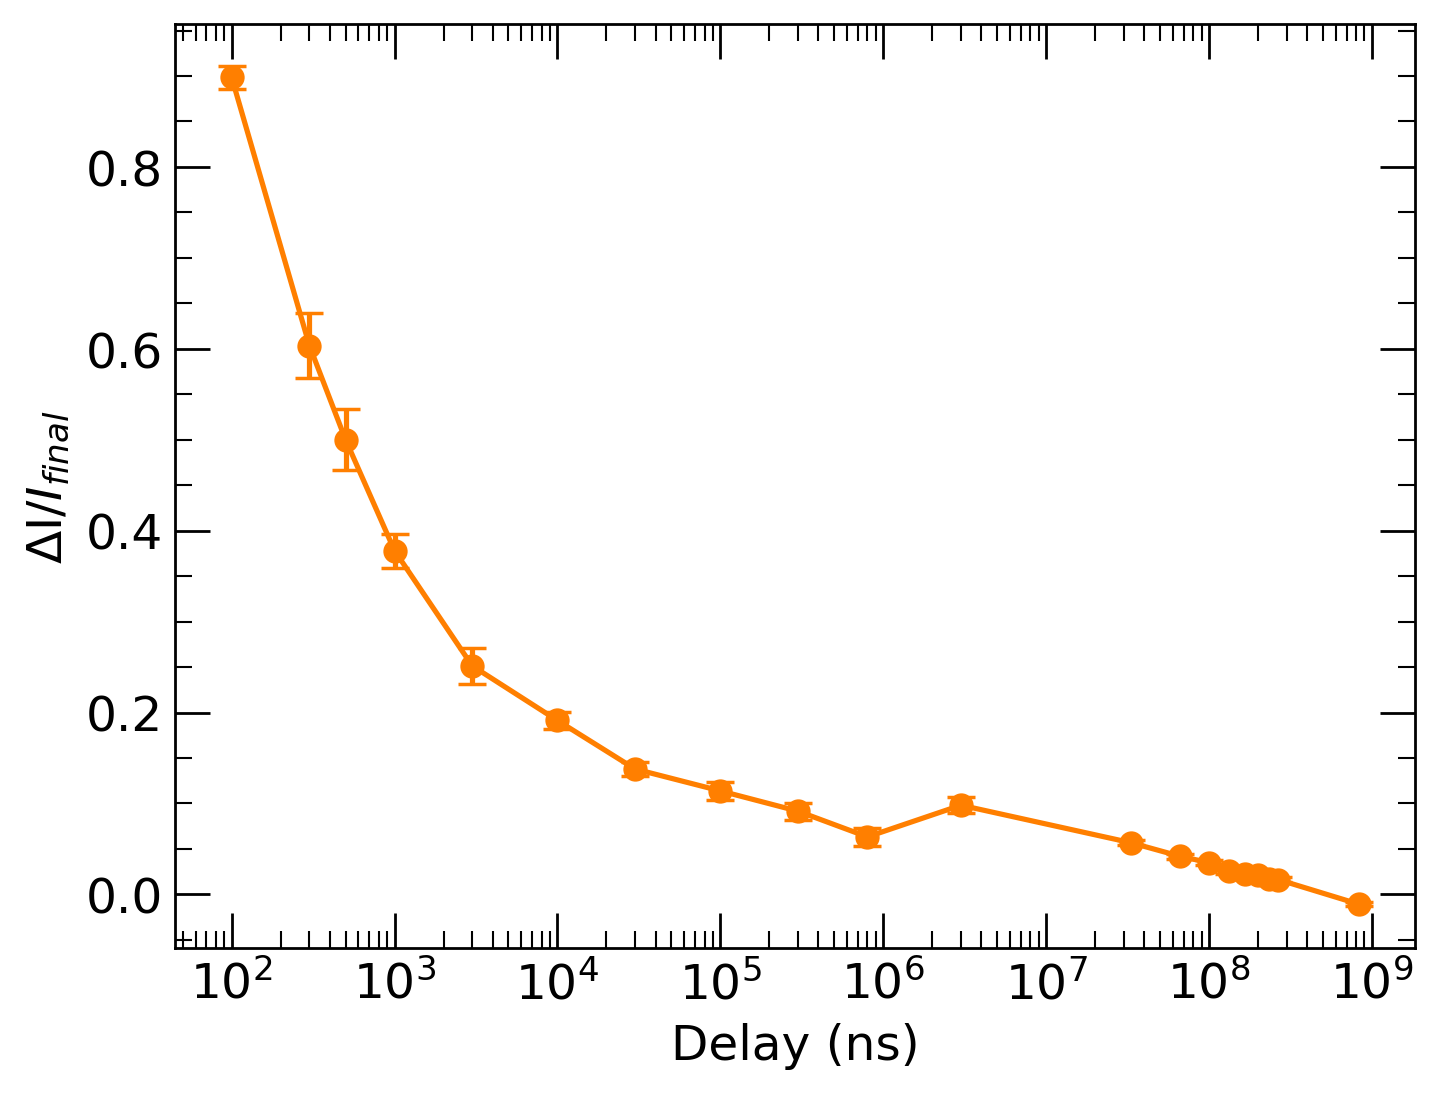

In [219]:
plt.figure()
delays_i,i0_means,i0_stds=plottable_lists_from_meanstd_dict(avg_i_ratios)
plt.errorbar(delays_i,np.subtract(np.ones_like(i0_means),i0_means),yerr=i0_stds,fmt='o-',capsize=4,color='#ff7f00')
# plt.plot(np.log10(delays),np.log10(np.subtract(np.ones_like(i0_means),i0_means)),'o-',color='#ff7f00')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Delay (ns)')
plt.ylabel('$\Delta$I/$I_{final}$')
# plt.ylim([0,1])
# plt.grid(True)
# plt.savefig(os.path.join(figsaveloc,'epix{}_intensity_ratio_difference_delay_curve.png'.format(detector)))

In [111]:
print(delays[:-3],np.subtract(np.ones_like(i0_means[:-3]),i0_means[:-3]))
stats.linregress(np.log10(delays),np.log10(np.subtract(np.ones_like(i0_means),i0_means)))

[1.e+02 3.e+02 5.e+02 1.e+03 3.e+03 1.e+04 3.e+04 1.e+05 3.e+05 8.e+05] [0.8984759  0.6036347  0.50022707 0.37802637 0.25130039 0.19128778
 0.1378627  0.11386271 0.09152572 0.06326817]


LinregressResult(slope=-0.22066409038476514, intercept=0.24712272476297736, rvalue=-0.9695251056599191, pvalue=4.606666254490913e-08, stderr=0.016812338559316894, intercept_stderr=0.0839514221080414)

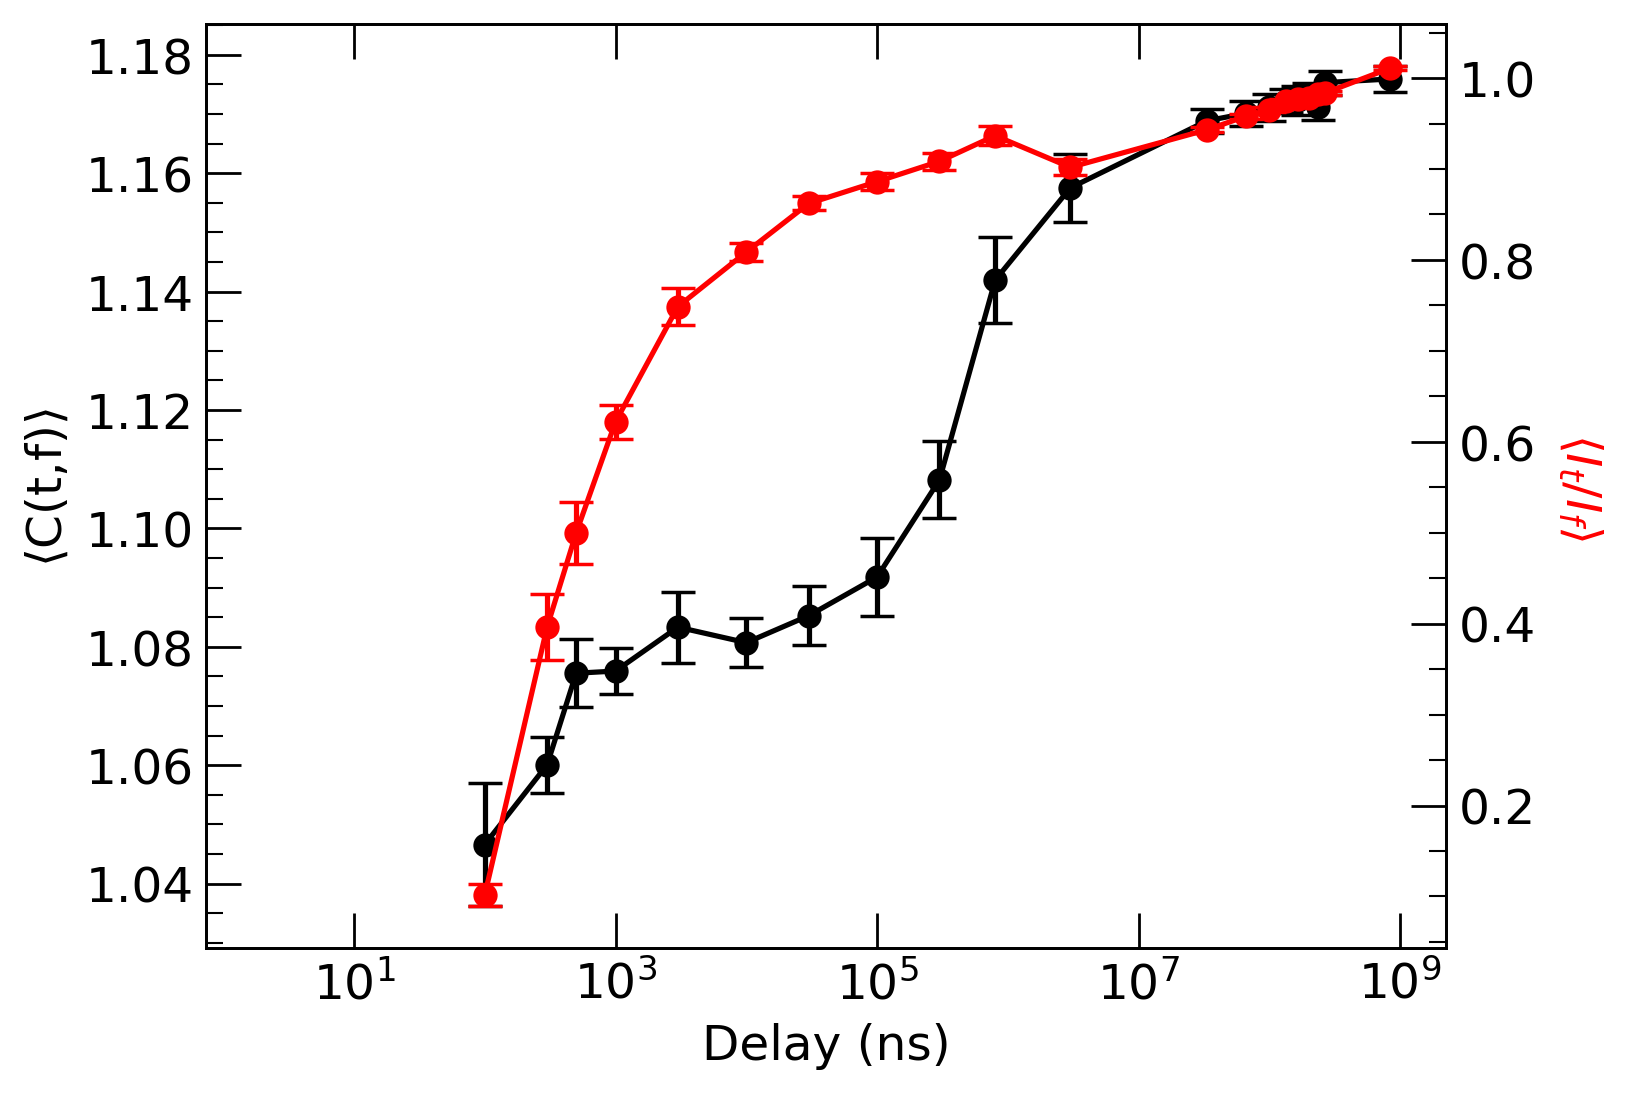

In [359]:
qoff_key=(0,0)
fig, ax_left=plt.subplots()
# fig.subplots_adjust(left=-0.1)
# delays,corr_means,corr_stds=plottable_lists_from_meanstd_dict(on_after_corrs_global_avg[qoff_key])
_,i_rat_means,i_rat_stds=plottable_lists_from_meanstd_dict(avg_i_ratios)
ax_left.errorbar(delays,corr_means,yerr=corr_stds,fmt='ko-',label='Normalized Correlation Difference',capsize=5)
#     ax_left.hlines(diff_pix_baseline_betas[pix_thres],0,1000)
ax_left.set_ylabel(r'$\langle$C(t,f)$\rangle$')
ax_left.set_xlabel('Delay (ns)')
ax_left.set_xscale('log')
# ax_left.set_xlim([30,1.1e8])
# ax_left.set_xticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8])
# ax_left.set_xticklabels(['100 ns',r'1 $\mu$s',r'10 $\mu$s',r'100 $\mu$s','1 ms','10 ms','100 ms'],rotation=45)
# ax_left.set_yticks(np.linspace(0,diff_pix_baseline_betas[pix_thres],11),labels=[])
# ax_left.yaxis.set_label_coords(-0.075,0.5)
# ax_left.legend()
# ax_left.set_ylim([1.2,1.7])
# ax_left.set_yticks(np.linspace(0,0.11,6),size=14)
ax_right = ax_left.twinx()
ax_right.errorbar(delays_i,i_rat_means,yerr=i_rat_stds,fmt='ro-',label='Intensity Ratio',capsize=5)
ax_right.set_xscale('log')
ax_right.set_ylabel(r'$\langle$$I_{t}$/$I_{f}$$\rangle$',color='red',size=14,rotation=270,labelpad=20)
# ax_right.set_ylim([0,1])
ax_right.set_yticks(np.linspace(0.2,1,5))
# ax_right.set_xlim([30,1.1e8])
# ax_right.set_xticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8])
# ax_right.set_xticklabels(['100 ns',r'1 $\mu$s',r'10 $\mu$s',r'100 $\mu$s','1 ms','10 ms','100 ms'],rotation=45)
# ax_right.legend(loc='upper left')
# plt.savefig(os.path.join(figsaveloc,'combined_C_I_ROI{}.svg'.format(ROI_size)))
plt.show()

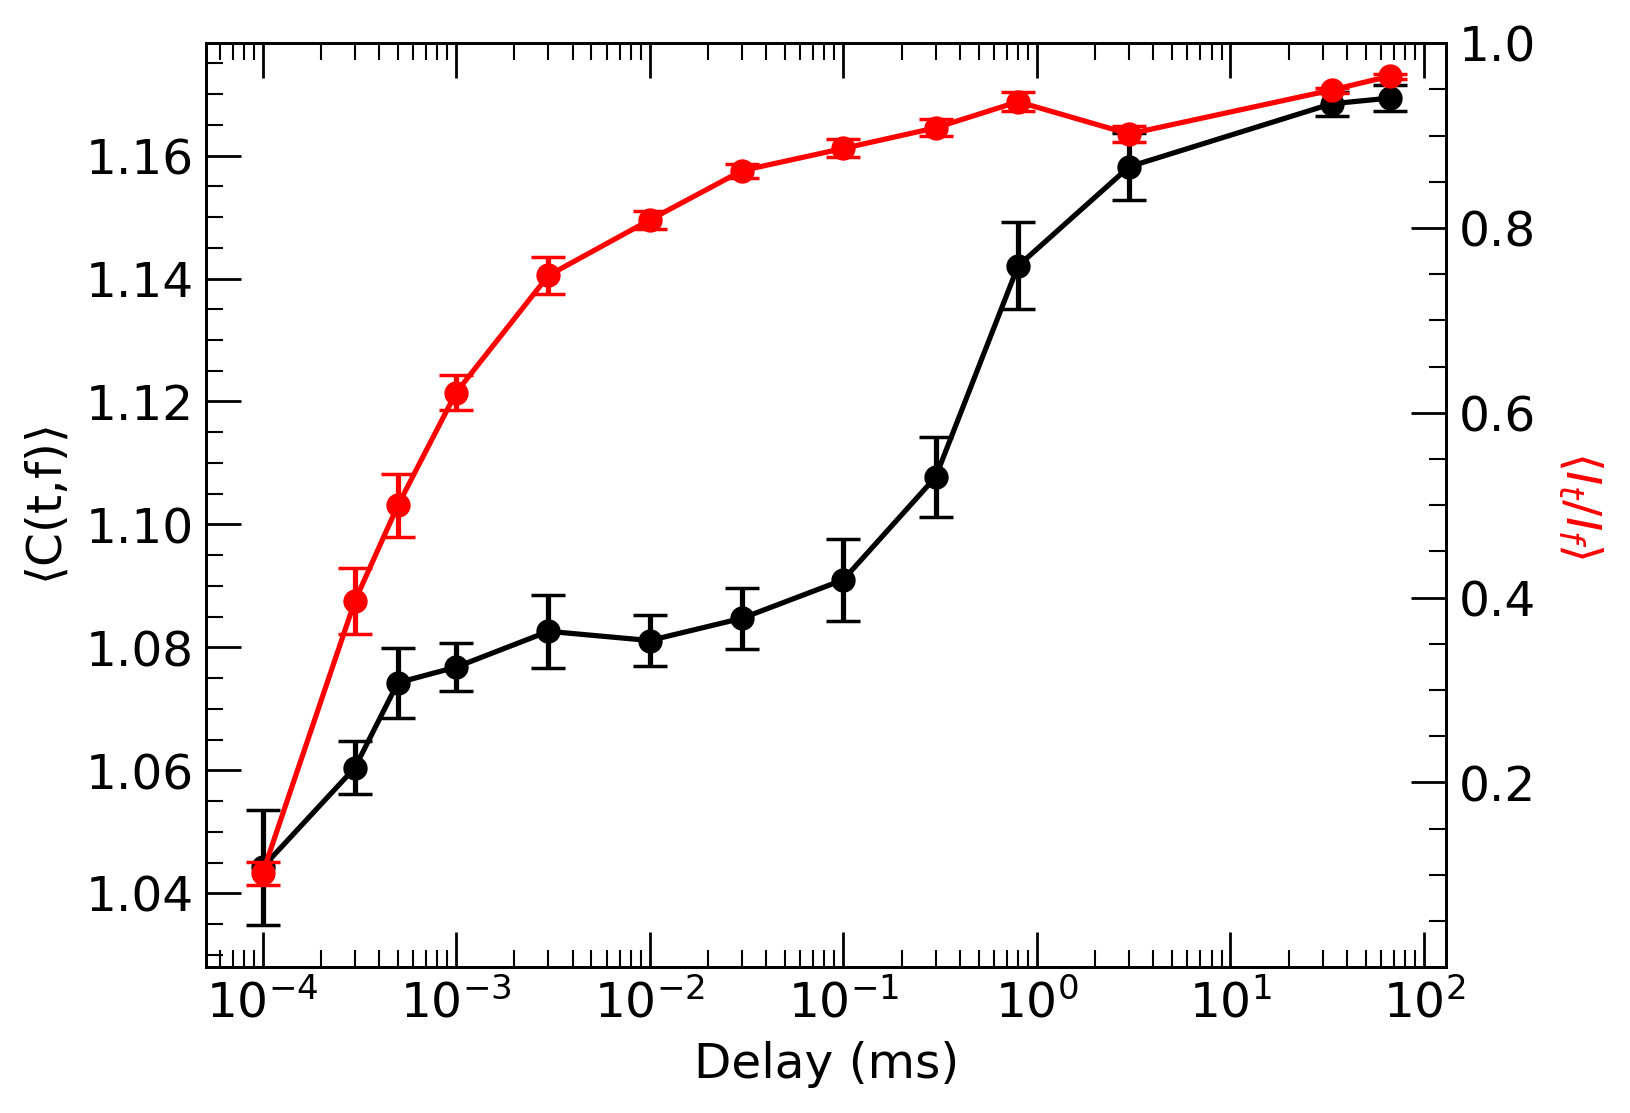

In [16]:
qoff_key=(0,0)
fig, ax_left=plt.subplots()
# fig.subplots_adjust(left=-0.1)
# delays,corr_means,corr_stds=plottable_lists_from_meanstd_dict(on_after_corrs_global_avg[qoff_key])
_,i_rat_means,i_rat_stds=plottable_lists_from_meanstd_dict(avg_i_ratios)
ax_left.errorbar(delays*1.0e-6,corr_means,yerr=corr_stds,fmt='ko-',label='Normalized Correlation Difference',capsize=5)
#     ax_left.hlines(diff_pix_baseline_betas[pix_thres],0,1000)
ax_left.set_ylabel(r'$\langle$C(t,f)$\rangle$',size=14)
ax_left.set_xlabel('Delay (ms)')
ax_left.set_xscale('log')

ax_right = ax_left.twinx()
ax_right.errorbar(np.array(delays_i)*1.0e-6,i_rat_means,yerr=i_rat_stds,fmt='ro-',label='Intensity Ratio',capsize=5)
ax_right.set_xscale('log')
ax_right.set_ylabel(r'$\langle$$I_{t}$/$I_{f}$$\rangle$',color='red',size=14,rotation=270,labelpad=20)
ax_right.set_ylim([0,1])
ax_right.set_yticks(np.linspace(0.2,1,5),size=14)
# plt.savefig(os.path.join(figsaveloc,'combined_C_I_ROI{}.svg'.format(ROI_size)))
plt.show()

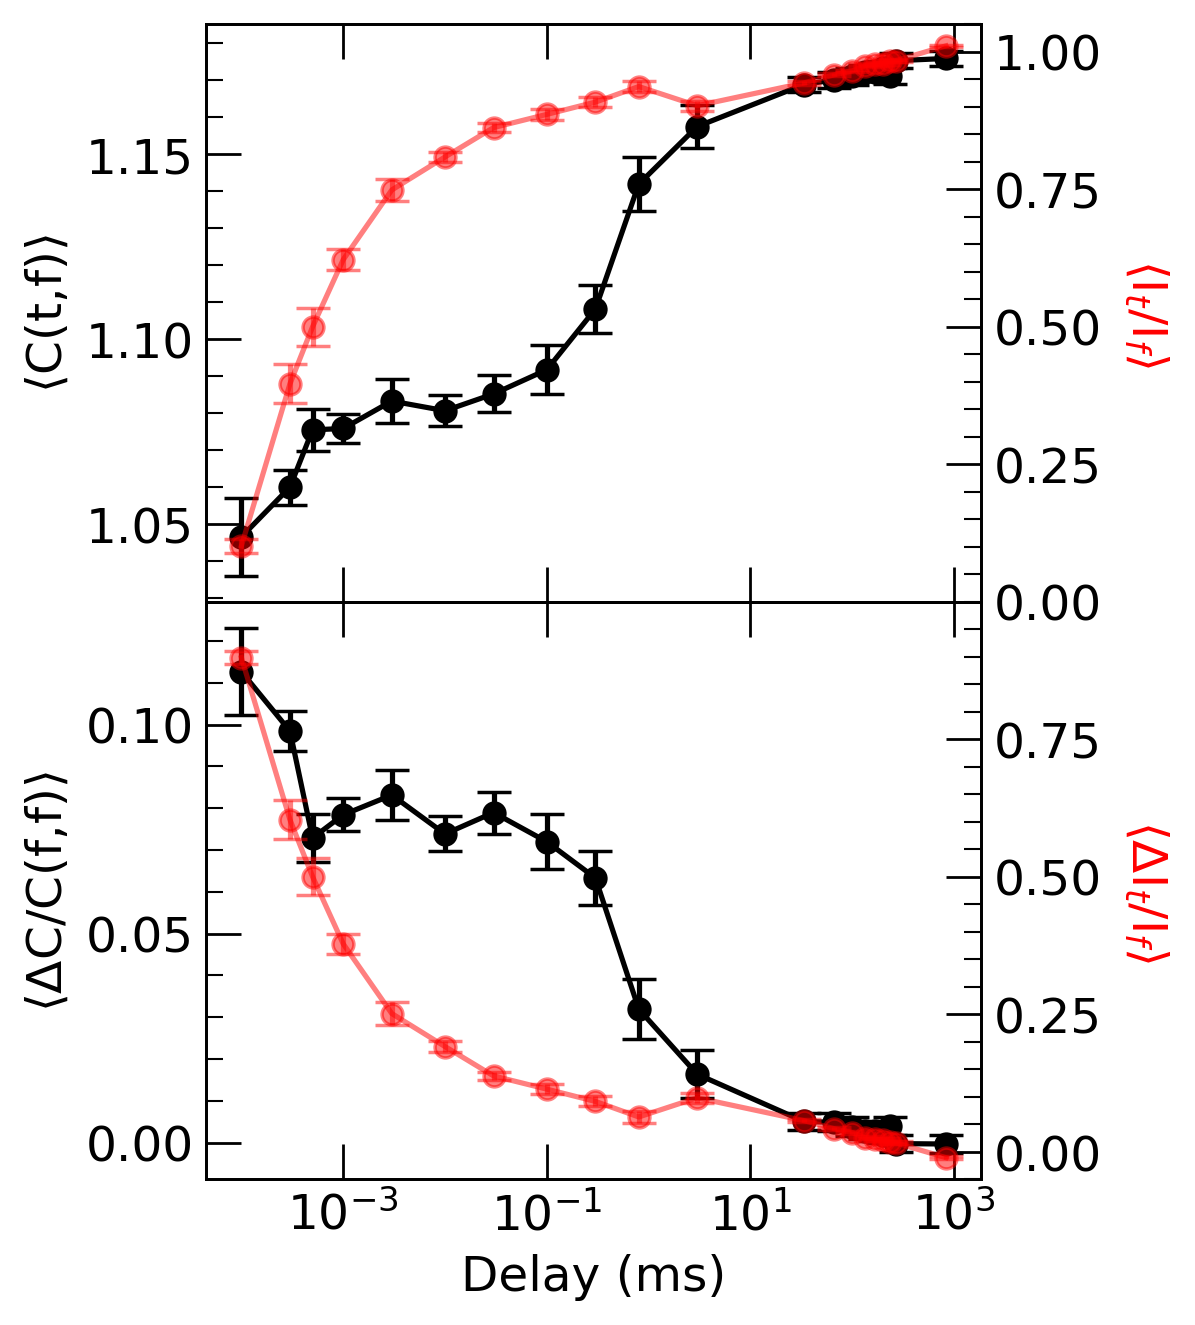

In [225]:
qoff_key=(0,0)
fig, (ax1_left,ax2_left)=plt.subplots(2,1,sharex=True,figsize=(4,6))
plt.subplots_adjust(hspace=0)
# fig.subplots_adjust(left=-0.1)
# delays,corr_means,corr_stds=plottable_lists_from_meanstd_dict(on_after_corrs_global_avg[qoff_key])
_,i_rat_means,i_rat_stds=plottable_lists_from_meanstd_dict(avg_i_ratios)
ax1_right = ax1_left.twinx()
ax1_right.errorbar(np.array(delays_i)*1.0e-6,i_rat_means,yerr=i_rat_stds,fmt='ro-',
                   label='Intensity Ratio',capsize=5,alpha=0.5)
ax1_right.set_xscale('log')
ax1_right.set_ylabel(r'$\langle$I$_{t}$/I$_{f}$$\rangle$',color='red',rotation=270,labelpad=20)

ax1_left.errorbar(C_data['delays']*1.0e-6,C_data['corr means'],yerr=corr_stds,fmt='ko-',label='Normalized Correlation Difference',capsize=5)
#     ax_left.hlines(diff_pix_baseline_betas[pix_thres],0,1000)
ax1_left.set_ylabel(r'$\langle$C(t,f)$\rangle$')
ax1_left.set_xscale('log')


ax1_right.set_ylim([0,1.05])
# ax1_right.set_yticks(np.linspace(0.2,1,5))

_,diffi_rat_means,diffi_rat_stds=plottable_lists_from_meanstd_dict(avg_diffI_ratios)
ax2_right = ax2_left.twinx()
ax2_right.errorbar(np.array(delays_i)*1.0e-6,diffi_rat_means,yerr=diffi_rat_stds,fmt='ro-',
                   label='Intensity Ratio',capsize=5,alpha=0.5)
ax2_right.set_xscale('log')
ax2_right.set_ylabel(r'$\langle$$\Delta$I$_{t}$/I$_{f}$$\rangle$',color='red',rotation=270,labelpad=20)

ax2_left.errorbar(diffC_data['delays']*1.0e-6,diffC_data['corr means'],yerr=corr_stds,fmt='ko-',label='Normalized Correlation Difference',capsize=5)
#     ax_left.hlines(diff_pix_baseline_betas[pix_thres],0,1000)
ax2_left.set_ylabel(r'$\langle \Delta$C$/$C(f,f)$\rangle$')
ax2_left.set_xscale('log')


ax2_right.set_ylim([-.05,1.])
ax2_right.set_yticks([0,0.25,0.5,0.75])
ax2_left.set_xlabel('Delay (ms)')

# plt.tight_layout()
plt.savefig(os.path.join(figsaveloc,'stacked_combined_CI_dcdI_ROI{}.svg'.format(ROI_size)))

plt.show()

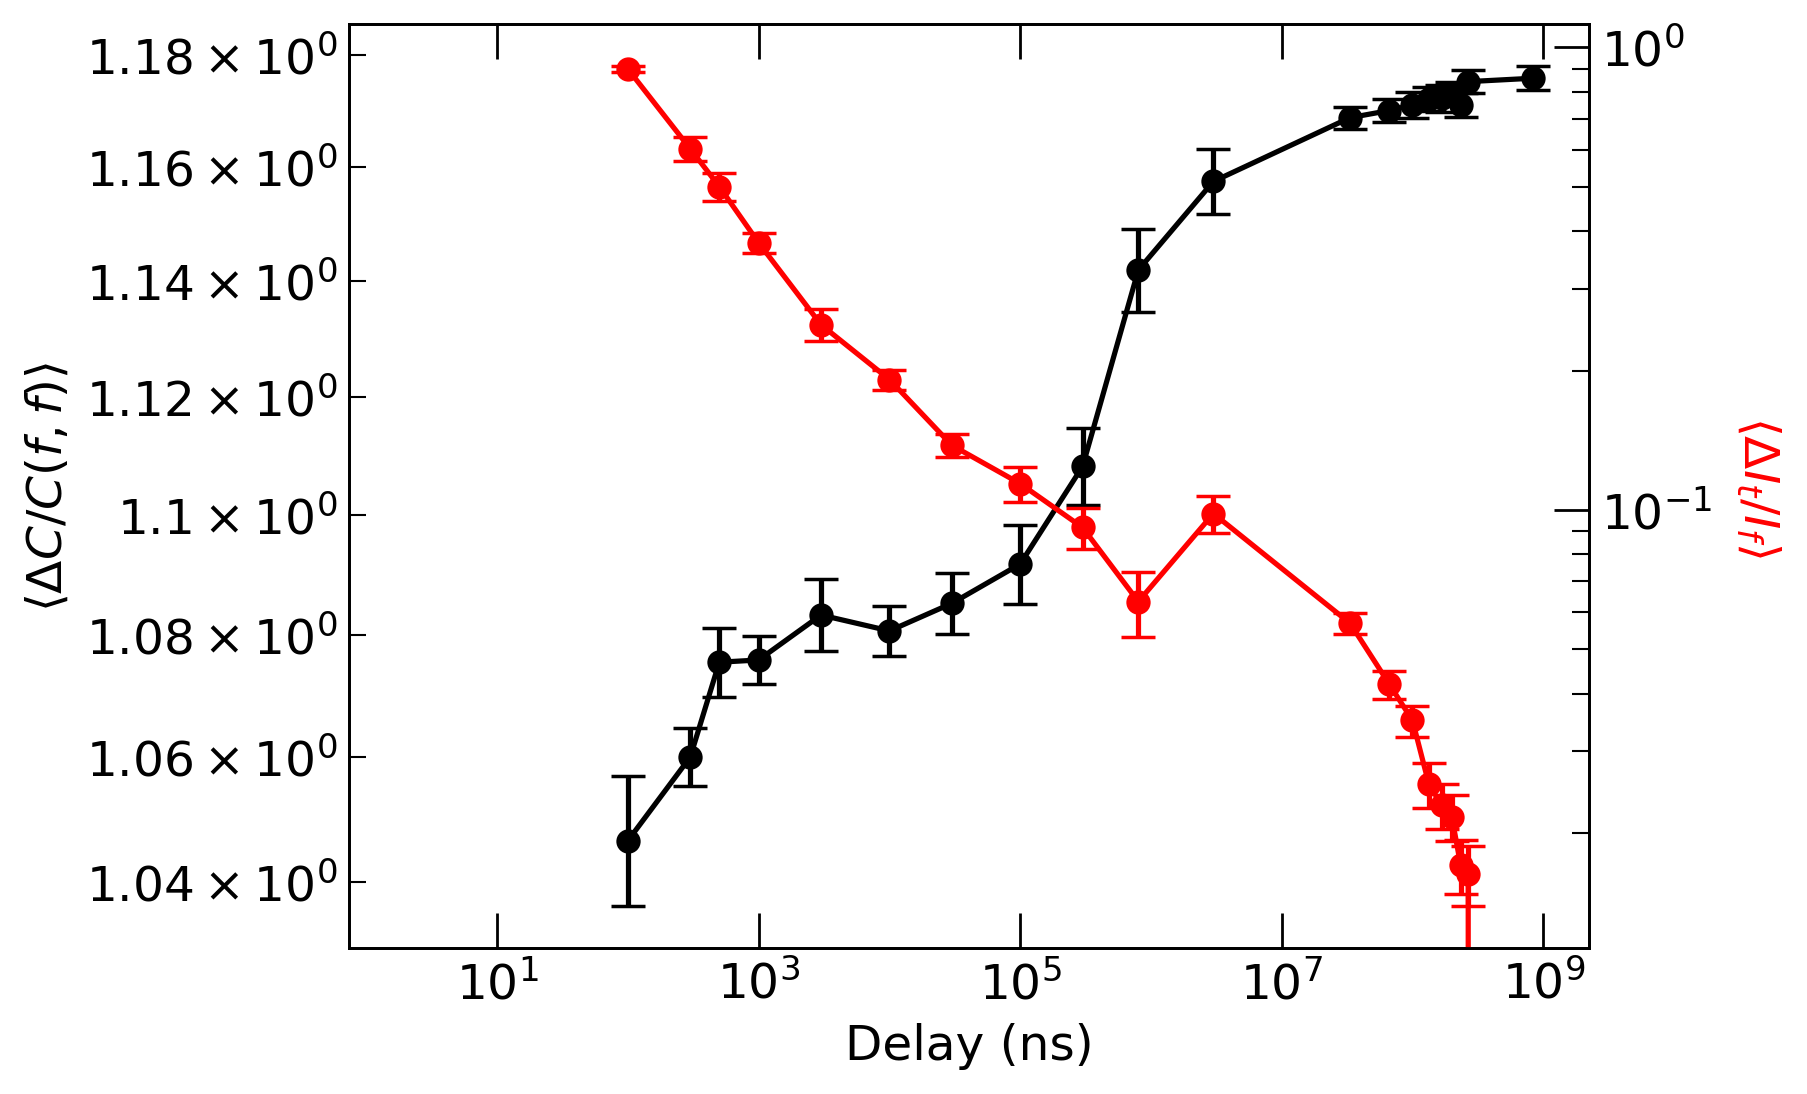

In [375]:
qoff_key=(0,0)
fig, ax_left=plt.subplots()
# fig.subplots_adjust(left=-0.1)
# delays,corr_means,corr_stds=plottable_lists_from_meanstd_dict(on_after_norm_corrs_diff_global_avg)
_,i_rat_diff_means,i_rat_diff_stds=plottable_lists_from_meanstd_dict(avg_i_ratios)
ax_left.errorbar(delays,corr_means,yerr=corr_stds,fmt='ko-',label='Normalized Correlation Difference',capsize=5)
#     ax_left.hlines(diff_pix_baseline_betas[pix_thres],0,1000)
ax_left.set_ylabel(r'$\langle \Delta C/C(f,f) \rangle$',size=14)
ax_left.set_xlabel('Delay (ns)')
ax_left.set_xscale('log')
# ax_left.set_xlim([30,1.1e8])
# ax_left.set_xticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8])
# ax_left.set_xticklabels(['100 ns',r'1 $\mu$s',r'10 $\mu$s',r'100 $\mu$s','1 ms','10 ms','100 ms'],rotation=45)
ax_left.set_yscale('log')
# ax_left.set_yticks(np.linspace(0,diff_pix_baseline_betas[pix_thres],11),labels=[])
# ax_left.yaxis.set_label_coords(-0.075,0.5)
# ax_left.legend()
# ax_left.set_ylim([0,0.13])
# ax_left.set_yticks(np.linspace(0,0.11,6),size=14)
ax_right = ax_left.twinx()
ax_right.errorbar(delays,np.subtract(np.ones_like(i0_means),i0_means),yerr=i_rat_diff_stds,fmt='ro-',label='Intensity Ratio',capsize=5)
ax_right.set_xscale('log')
# ax_right.set_xlim([30,1.1e8])
# ax_right.set_xticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8])
ax_right.set_ylabel(r'$\langle \Delta I_{t}/I_{f} \rangle$',color='red',size=14,rotation=270,labelpad=20)
# ax_right.set_xticklabels(['100 ns',r'1 $\mu$s',r'10 $\mu$s',r'100 $\mu$s','1 ms','10 ms','100 ms'],rotation=45)
ax_right.set_yscale('log')
# ax_right.set_ylim([0,1])
# ax_right.set_yticks(np.linspace(0.2,1,5),size=14)
# ax_right.set_yticks(np.linspace(0,1,6),size=14)
# ax_right.legend(loc='upper left')
# plt.savefig(os.path.join(figsaveloc,'combined_delC_delI_ROI{}-log.svg'.format(ROI_size)))

In [ ]:
h.close()